***
### Библиотеки

In [580]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import category_encoders as ce
import wikipedia as wp

import json
import urllib
import bs4
import time
import pickle

In [581]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from collections import Counter
from catboost import CatBoostRegressor

from scipy.stats import shapiro, ttest_ind

In [582]:
# убираем предупреждения
from warnings import filterwarnings
filterwarnings("ignore")

***
### Служебные функции и глобальные переменные:

In [583]:
# глобальные переменные

current_year = 2023 # текущий год
earliest_year = 1800 # минимальный год для расчёта возраста
value_no_age = 999 # значение для заполнения пропущенных данных в признаке возраста
acre_to_sqft = 43560 # количество кв. футов в акре
sigma = 3 # значение сигма для поисков выбросов по методу z-отклонений
corr_thresh = 0.8 # предел по мультиколлинеарности
random_state = 100 

max_stories = 100 # максимальное количество этажей

min_sqft = 150 # минимальная площадь объекта недвижимости
max_sqft = 1e+4 # максимальная площадь объекта недвижимости
max_parking_lots = 10 # максимальное значение кол-ва парковочных мест
max_lotsize = 1e+6 # максимальный размер участка

alpha = 0.05 # уровень значимости для стат. тестов

In [584]:
# обозначения штатов
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [585]:
# Функция для проверки JSON-строк.

def json_check(json_str, error=False):
    try:
        _ = json.loads(json_str)
    except json.JSONDecodeError as e:
        return 'error'

In [586]:
# Функция для создания маски по ключевым словам из списка.
# В зависимости от значения оператора возвращает маску, где есть хотя бы одно из слов в списке word_list,
# либо маску, где есть все слова из списка.

def keyword_mask(data, column, word_list, operator='or'):  
    if operator == 'or':
        mask_full = False
        for prop in word_list:
            mask_ = data[column].str.find(prop) + 1
            mask_ = mask_.astype(bool)
            mask_full = mask_full | mask_
    elif operator == 'and':
        mask_full = True
        for prop in word_list:
            mask_ = data[column].str.find(prop) + 1
            mask_ = mask_.astype(bool)
            mask_full = mask_full & mask_
    return mask_full

In [587]:
# Функция для очистки данных по методу Тьюки.

def outliers_iqr(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [588]:
# Функция для парсинга расстояний и времени езды между городами.
# Принимает на вход массив кортежей из пары городов в формате ("город,ШТАТ","город,ШТАТ"), где пробелы заменены на %20
# возращает три словаря, где в качестве ключей пары городов, а в качестве значений:
# distance_dict - расстояния между городами.
# time_dict - время в пути между городами (в минутах).
# issues_dict - код ошибки, если нунжые данные не были найдены при парсинге.

def bing_distance_time_parser(city_pairs):
    # адрес сайта для парсинга + ключ
    api_key = 'Ap2Om668CrSJ0IX_TONtzk6_C4ntDAHPU9Vtrsyjci7rAoDHU_zkn0ITxyLgRIo6'
    base = 'http://dev.virtualearth.net/REST/V1/Routes/Driving'

    distance_dict = {}
    time_dict = {}
    issues_dict = {}

    city_pair_list = city_pairs.tolist()
    for pair in city_pairs:
        # собираем url
        url = '{}?o=xml&wp.0={}&wp.1={}&avoid=minimizeTolls&distanceUnit=mi&key={}'.format(base, pair[0], pair[1], api_key)
        try:
            read_url = urllib.request.urlopen(url)
            read_url_read = read_url.read()
            read_url_code = read_url.getcode()
            if read_url_code == 200:
                data_url = bs4.BeautifulSoup(read_url_read,'xml')
                distance_dict[pair] = float(data_url.find('TravelDistance').text)
                time_dict[pair] = float(data_url.find('TravelDuration').text) / 60 # переводим время в минуты
                city_pair_list.remove(pair)
                print(f'Pair {pair} succefully parsed', end='\r')
            else:
                issues_dict[pair] = read_url_code
                print(f'Pair {pair} got an issue, code = {read_url_code}')
            time.sleep(0.5) # не будем сильно докучать запросами, тем более у нас всего около 2000 записей
        except urllib.error.HTTPError as e:
            print('Error!', e)
            print(f'Pair {pair} is an issue!')
            issues_dict[pair] = e
            city_pair_list.remove(pair)
    return distance_dict, time_dict, issues_dict

In [589]:
# Функция для отрисовки большого количества графиков на основе seaborn
# Не меньше 3 признаков в аргументе features!
# Параметры:
# data - датасет.
# features - исследуемые признаки.
# target - исследуемая переменная (обычно целевая).
# width - общая ширина.
# height - высота каждого отдельного графика.
# scale - размер шрифта.
# mode - режими отрисовки: 'boxplot', 'barplot', 'histplot', 'scatterplot'.
# bins, kde - параметры seaborn.histplot.

def multiplot(data, features, target, width=16, height=2, scale=1, mode='barplot', bins=30, kde=False):
    if len(features) < 3: # проверка на количество признаков
        print(f'Too less feature arguments, need 3 at least, but only {len(features)} were given')
    else:  
        sns.set(font_scale=scale)    
        
        # отрисовка фигуры в нужных размерах
        if data[features].shape[1] % 2 == 0:
            _, axes = plt.subplots(nrows=data[features].shape[1] // 2, ncols=2, figsize=(width, height*data[features].shape[1]), constrained_layout=True)
        else:
            _, axes = plt.subplots(nrows=data[features].shape[1] // 2 + 1, ncols=2, figsize=(width, height*data[features].shape[1]), constrained_layout=True)
        
        # отрисовка графиков
        if mode == 'barplot':
            for i, feature in enumerate(features):
                sns.barplot(ax=axes[i // 2, i % 2], x=data[feature], y=data[target], hue=data[feature], legend=False)
                axes[i // 2, i % 2].set_title('feature: ' + feature)
        elif mode == 'histplot':
            for i, feature in enumerate(features):
                sns.histplot(ax=axes[i // 2, i % 2], x=data[feature], kde=kde, bins=bins)
                axes[i // 2, i % 2].set_title('feature: ' + feature)
        elif mode == 'boxplot':
            for i, feature in enumerate(features):
                sns.boxplot(ax=axes[i // 2, i % 2], x=data[feature])
                axes[i // 2, i % 2].set_title('feature: ' + feature)
        elif mode == 'scatterplot':
            for i, feature in enumerate(features):
                sns.scatterplot(ax=axes[i // 2, i % 2], x=data[feature], y=data[target])
                axes[i // 2, i % 2].set_title('feature: ' + feature)

In [590]:
# Функция выводит наиболее часто встречающиеся слова столбца.
# Требует библиотеку collections.
# Принимает на вход датасет и столюец, возвращает Counter со всеми словами

def common_words(data, feature):
    data = data[feature].fillna('nan').str.lower().copy()
    count_ = Counter()
    data = data.str.replace(' ', '_').str.replace(r'[\W\d]', '', regex=True).str.replace(r'_+', '_', regex=True)   
    data = data.str.split('_')
    data = data.map(lambda x: count_.update(x))
    return count_

In [591]:
# Функция для проверки корреляции.
# Принимает на вход корреляционную матрицу и целевой признак. В качестве доп. параметра есть предел
# по корреляционному коэф-ту 'thresh'.
# Возвращает датафрейм, где в 1-м столбеце - пара коррелирующих признаков со значением корреляции,
# а во 2-м и 3-м - значения корреляции каждого из двух признаков с целевым

def corr_matrix_check(corr_matrix, target, thresh=0.85):
    cols_to_drop_corr = {'pair':[], 'corr_with_target_1':[], 'corr_with_target_2':[]}
    for i, ind in enumerate(corr_matrix.index):
        cols = list(corr_matrix.columns)[i:]
        cols.remove(ind)
        for col in cols:
            corr = abs(corr_matrix.loc[ind, col])
            if corr > thresh:
                cols_to_drop_corr['pair'].append(col + '-' + ind + '=' + str(corr))
                cols_to_drop_corr['corr_with_target_1'].append(col + '=' + str(corr_matrix.loc[col, target]))
                cols_to_drop_corr['corr_with_target_2'].append(ind + '=' + str(corr_matrix.loc[ind, target]))
    return pd.DataFrame.from_dict(cols_to_drop_corr, orient='columns')

In [592]:
# Функция для отрисовки значимости признаков для моделей, сортирует признаки по значимости, принимает на вход два массива: названия признаков и значимость

def feature_importances_plot(feature_names, feature_importances):
    # проверяем порядок значений
    if np.sum(feature_importances) == 1:
        feature_importances *= 100
    # создаём упорядоченный словарь, в котором в качестве ключей будут признаки, а в качестве значений - значимость этих признаков  
    features_dict = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}
    # сортируем его и снова собираем
    features_dict = sorted(features_dict.items(), reverse=True, key=lambda x: x[1])
    features_dict = {features_dict[i][0]: features_dict[i][1] for i in range(len(features_dict))}

    # отрисовываем график
    plt.figure(figsize=(12,14))
    sns.set(font_scale=1.1)
    sns.barplot(x=features_dict.values(), y=features_dict.keys(), hue=features_dict.keys(), orient='h', legend=False)
    
    # добавляет значимость для каждого признака
    features_values = list(features_dict.values())
    sns.set(font_scale=1.0)
    for i in range(len(features_dict)):
        plt.text(features_values[i] + 0.05, i + 0.25, round(features_values[i], 2))

    plt.title('Значимость признаков')
    plt.xlabel('Значимость')
    plt.ylabel('Признаки')
    plt.xticks(rotation=90)
    plt.show();

In [593]:
# функция для подсчета и вывода метрик MAE, MAPE и R^2

def show_scores(X_train_, X_test_, y_train_, y_test_, model, out=False):
    y_train_pred = model.predict(X_train_)
    y_test_pred = model.predict(X_test_)
    mae_train = mean_absolute_error(y_train_, y_train_pred)
    mae_test = mean_absolute_error(y_test_, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_, y_test_pred)
    r2_train = r2_score(y_train_, y_train_pred)
    r2_test = r2_score(y_test_, y_test_pred)
    print(f'Тренировочная выборка: МAЕ = {mae_train:.3f}, MAPE = {mape_train:.3f}, R^2 = {r2_train:.3f}')
    print(f'Тестовая выборка: МAЕ = {mae_test:.3f}, MAPE = {mape_test:.3f}, R^2 = {r2_test:.3f}')
    if out:
        return (mae_train, mape_train, r2_train), (mae_test, mape_test, r2_test)
    else:
        return None

***
### Загрузка данных

Загрузим наши данные:

In [594]:
data = pd.read_csv('data/data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Посмотрим на типы данных:

In [595]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Все признаки находятся в формате *object*. Для начала уберём дубликаты, избавимся от пропусков и преобразуем признаки в нормальный вид.

***
### Дубликаты

In [596]:
mask = data.duplicated()
print(f'Количество дубликатов: {mask.sum()}')

Количество дубликатов: 50


Уберём дубликаты:

In [597]:
data = data.drop_duplicates()

***
### Пропуски и первичное преобразование признаков

Посмотрим на пропуски:

In [598]:
data.isna().sum().sort_values(ascending=False)

private pool    372954
mls-id          352193
PrivatePool     336825
fireplace       274023
stories         150673
baths           106308
beds             91254
MlsId            66869
sqft             40550
status           39917
propertyType     34733
target            2480
city                34
street               2
zipcode              0
schools              0
state                0
homeFacts            0
dtype: int64

Что ж, пропусков довольно много.

Для начала удалим строки, где отсутствует признак ***target***, нам они никак не пригодятся, а также 2 пропуска признака ***street***:

In [599]:
data = data.dropna(subset=['target', 'street'])

Обработаем признаки ***status*** и ***propertyType***. Заполним пропущенные значения и сократим количество категорий.

Начнём с признака ***status***. Создадим следующие категории:
- *sale* - открыт для покупки;
- *foreclosure* - продажа в связи с невыплатой ипотеки;
- *rent* - аренда;
- *construction* - новый или строящийся дом;
- *contract* - получено предложение о покупке;
- *pending* - договор заключен, но сделка не завершена;
- *contingent* - особые условия покупки;
- *other* - остальное;
- *unknown* - пропуски.

In [600]:
status_list = ['contingent', 'contract', 'rent', 'pending', 'foreclosure', 'construction', 'sale']

data['status'] = data['status'].fillna('unknown')

# приведём строки к нижнему регистру
data['status'] = data['status'].str.lower()

# с помощью масок отфильтруем нужные признаки
data.loc[keyword_mask(data, 'status', ['conting']), 'status'] = 'contingent'
data.loc[keyword_mask(data, 'status', ['contr']), 'status'] = 'contract'
data.loc[keyword_mask(data, 'status', ['rent']), 'status'] = 'rent'
data.loc[keyword_mask(data, 'status', ['pend']), 'status'] = 'pending'
data.loc[keyword_mask(data, 'status', ['fore', 'clos', 'pre']), 'status'] = 'foreclosure'
data.loc[keyword_mask(data, 'status', ['constr', 'new']), 'status'] = 'construction'
data.loc[keyword_mask(data, 'status', ['sal', 'activ']), 'status'] = 'sale'

data['status'] = data['status'].apply(lambda x: x if x in status_list else 'other')
data['status'].value_counts()

sale            305304
other            42990
foreclosure       9600
construction      6148
pending           5315
contract          3768
contingent        1116
rent               412
Name: status, dtype: int64

Теперь перейдём к признаку ***propertyType***. Создадим для него следующие категории:
- *land* - продажа земельного участка;
- *multi* - продажа многоквартирных домов;
- *single-family* - дом для одной семьи;
- *apartments* - апартаменты;
- *condo* - квартира в кондоминимуме;
- *townhouse* - таунхаус;
- *mobile* - сборные дома;
- *coop* - кооперативное жильё;
- *cottage* - всякие домики для отдыха: коттеджи, бунгало и пр.;
- *farm* - фермы, ранчо, дома в сельской местности;
- *other* - другое;
- *unknown* - пропуски.

In [601]:
property_list = ['land', 'multi', 'single_family_home', 'apartments', 'condo', 'townhouse', 'mobile', 'coop', 'cottage', 'farm']

data['propertyType'] = data['propertyType'].fillna('unknown')

# приведём строки к нижнему регистру
data['propertyType'] = data['propertyType'].str.lower()

# с помощью масок отфильтруем нужные признаки
data.loc[keyword_mask(data, 'propertyType', ['land']), 'propertyType'] = 'land'
data.loc[keyword_mask(data, 'propertyType', ['mult']), 'propertyType'] = 'multi'
data.loc[keyword_mask(data, 'propertyType', ['condo', 'high', 'rise', 'penth']), 'propertyType'] = 'condo'
data.loc[keyword_mask(data, 'propertyType', ['sing']), 'propertyType'] = 'single_family_home'
data.loc[keyword_mask(data, 'propertyType', ['apart']), 'propertyType'] = 'apartments'
data.loc[keyword_mask(data, 'propertyType', ['town']), 'propertyType'] = 'townhouse'
data.loc[keyword_mask(data, 'propertyType', ['coo']), 'propertyType'] = 'coop'

property_mobile_list = ['manuf', 'mobil', 'prefa', 'modul', 'mo2']
data.loc[keyword_mask(data, 'propertyType', property_mobile_list), 'propertyType'] = 'mobile'

property_cottage_list = ['cotta', 'bung', 'cabin', 'ca2', 'gard']
data.loc[keyword_mask(data, 'propertyType', property_cottage_list), 'propertyType'] = 'cottage'

property_farm_list = ['farm', 'ranch', 'detach']
data.loc[keyword_mask(data, 'propertyType', property_farm_list), 'propertyType'] = 'farm'

data['propertyType'] = data['propertyType'].apply(lambda x: x if x in property_list else 'other')
data['propertyType'].value_counts()

single_family_home    188324
other                  55526
condo                  53587
land                   31449
townhouse              18526
multi                  12453
farm                    5554
coop                    3797
mobile                  3552
cottage                 1069
apartments               816
Name: propertyType, dtype: int64

Отметим, что при продаже земельного участка дом не предполагается. Таким образом, признаки ***baths***, ***beds***, ***stories***, ***private pool*** и ***fireplace*** нужно сделать равными нулю, если продаётся только замельный участок:

In [602]:
data.loc[data.propertyType == 'land', ['baths', 'beds', 'stories', 'private pool', 'PrivatePool', 'fireplace', 'sqft']] = '0'

Взглянем ещё раз на пропуски:

In [603]:
data.isna().sum().sort_values(ascending=False)

mls-id          349716
private pool    339053
PrivatePool     303412
fireplace       241674
stories         120868
baths            78208
MlsId            64468
beds             62081
sqft             23664
city                34
state                0
status               0
zipcode              0
schools              0
homeFacts            0
street               0
propertyType         0
target               0
dtype: int64

Можно смело утверждать, что площадь дома/квартиры является одним из определящих в смысле цены. Поэтому удалим 6% пропусков в этом признаке:

In [604]:
data = data.dropna(subset=['sqft'])

Теперь преобразуем признак ***sqft*** в числовой:

In [605]:
# уберём все нецифровые символы
data['sqft'] = data['sqft'].str.replace(r'[^\d]', '', regex=True)

# переведём в цифровой формат
data['sqft'] = pd.to_numeric(data['sqft'], errors='coerce', downcast='float')

# установим значение жилой площади = 0 для земельных участков
data.loc[(data.propertyType == 'land') & data.sqft.isna(), 'sqft'] = 0 # ещё раз проверим пропуски на соответствие типу недвижимости

# количество пропусков из-за преобразований в числовой формат
print(f'Всего пропусков из-за преобразований: {data.sqft.isna().sum()}')

Всего пропусков из-за преобразований: 811


Крайне мало пропусков, удалим их:

In [606]:
data = data.dropna(subset=['sqft'])

Займёмся признаками ***baths***, ***beds*** и ***stories***.

**Ванные комнаты** (***baths***). Можно узнать, что такие количества, как $3.75$ или $4.5$ имеют место быть в США. На практике это означает наличие неполных ванных комнат (унитаз + раковина). Поэтому мы оставим такие числа при преобразовании признака:

In [607]:
# сделаем словарь для преобразования протых числительных в цифры
nums = {'one':'1', 'two':'2', 'three':'3', 'four':'4', 'five':'5', 'six':'6', 'seven':'7', 'eight':'8', 'nine':'9', 'ten':'10'}

In [608]:
nan_baths = data.baths.isna().sum()

# сделаем замены для простых числительных
data['baths'] = data['baths'].str.lower()
for word, replacement in nums.items():
    data['baths'] = data['baths'].str.replace(word, replacement)

# сделаем замены запятой на точку и уберём все не-цифры, кроме точки
data['baths'] = data['baths'].str.replace(',', '.')
data['baths'] = data['baths'].str.replace(r'[^\d.]', '', regex=True)

# переведём в числовой формат и посмотрим получившиеся пропуски
data['baths'] = pd.to_numeric(data['baths'], errors='coerce', downcast='float')
print(f'Всего пропусков из-за преобразований: {data.baths.isna().sum() - nan_baths}')

Всего пропусков из-за преобразований: 1335


**Этажность**. Разберёмся с признаком ***stories***:

In [609]:
nans_stories = data.stories.isna().sum()

# сделаем замены для простых числительных
data['stories'] = data['stories'].str.lower()
for word, replacement in nums.items():
    data['stories'] = data['stories'].str.replace(word, replacement)

# сделаем замены запятой на точку и уберём все не-цифры, кроме точки
data['stories'] = data['stories'].str.replace(',', '.')
data['stories'] = data['stories'].str.replace(r'[^\d.]', '', regex=True)

# переведём в числовой формат и посмотрим получившиеся пропуски
data['stories'] = pd.to_numeric(data['stories'], errors='coerce', downcast='float')
print(f'Всего пропусков из-за преобразований: {data.stories.isna().sum() - nans_stories}')

Всего пропусков из-за преобразований: 1873


**Спальни** (***beds***). Преобразуем признак в числовой формат:

In [610]:
nans_beds = data.beds.isna().sum()

# сделаем замены для простых числительных
data['beds'] = data['beds'].str.lower()
for word, replacement in nums.items():
    data['beds'] = data['beds'].str.replace(word, replacement)

# сделаем замены запятой на точку и уберём все не-цифры, кроме точки
data['beds'] = data['beds'].str.replace(',', '.')
data['beds'] = data['beds'].str.replace(r'[^\d.]', '', regex=True)

# переведём в числовой формат и посмотрим получившиеся пропуски
data['beds'] = pd.to_numeric(data['beds'], errors='coerce', downcast='float')
print(f'Всего пропусков из-за преобразований: {data.beds.isna().sum() - nans_beds}')

Всего пропусков из-за преобразований: 14824


Теперь заполним пропущенные значения модой, взятой по каждой категории признака ***propertyType***:

In [611]:
mode_baths = {}
mode_beds = {}
mode_stories = {}
nan_baths = data.baths.isna()
nan_beds = data.beds.isna()
nan_stories = data.stories.isna()

# возьмём все категории признака 'propertyType' для всех пропущенных признаков
property_cats = data.loc[nan_baths | nan_beds | nan_stories, 'propertyType'].value_counts().index.tolist()

# Запишем наш словарь с модами
for cat in property_cats:
    try:
        mode_baths[cat] = data.loc[data.propertyType == cat, 'baths'].mode()[0]
    except KeyError as error:
        mode_baths[cat] = np.NaN
    try:
        mode_beds[cat] = data.loc[data.propertyType == cat, 'beds'].mode()[0]
    except KeyError as error:
        mode_beds[cat] = np.NaN
    try:
        mode_stories[cat] = data.loc[data.propertyType == cat, 'stories'].mode()[0]
    except KeyError as error:
        mode_stories[cat] = np.NaN

**NaN** есть только в модах признака ***beds***. Заменим их и заполним пропуски во всех трёх признаках:

In [612]:
mode_beds['detached'] = mode_beds['single_family_home']
mode_beds['high-rise'] = mode_beds['condo']
mode_beds['cottage'] = mode_beds['other']

data.loc[nan_baths, 'baths'] = data.loc[nan_baths, 'propertyType'].map(mode_baths)
data.loc[nan_beds, 'beds'] = data.loc[nan_beds, 'propertyType'].map(mode_beds)
data.loc[nan_stories, 'stories'] = data.loc[nan_stories, 'propertyType'].map(mode_stories)

Теперь посмотрим на признаки ***fireplace***, ***private pool*** и ***PrivatePool***. Предположим, что *NaN* здесь не пропуск, а признак отсутствия бассейна или камина. Заполним пропуски и сделаем эти признаки бинарными:
1. Признак ***fireplace***. NaN - $0$ (камина нет), остальные (не берём в расчёт количество каминов, топливо и пр.) - $1$ (камин есть).
2. Признаки ***private pool*** и ***PrivatePool***. NaN - $0$ (бассейна нет), остальное - $1$ (бассейн есть). Поскольку признаков два, объединим их с помощью логического **ИЛИ**.

In [613]:
# маска отсутствия камина
mask_fireplace = (data['fireplace'] == 'No') | (data['fireplace'] == 'Not Applicable') | (data['fireplace'] == '0')

# заполняем пропуски и переводим признак в бинарных формат
data['fireplace'] = data['fireplace'].fillna('0')
data.loc[mask_fireplace, 'fireplace'] = '0'
data['fireplace'] = data['fireplace'].apply(lambda x: '0' if x=='0' else '1')

data['fireplace'] = data['fireplace'].astype(np.int8)
data['fireplace'].value_counts()

0    252360
1     97818
Name: fireplace, dtype: int64

In [614]:
# заполняем пропуски
data['PrivatePool'] = data['PrivatePool'].fillna('0')
data['private pool'] = data['private pool'].fillna('0')

# приводим строки к нижнему регистру
data['PrivatePool'] = data['PrivatePool'].str.lower()
data['private pool'] = data['private pool'].str.lower()

# меняем значения
data['PrivatePool'] = data['PrivatePool'].map({'yes': '1', '0': '0'})
data['private pool'] = data['private pool'].map({'yes': '1', '0': '0'})

data['PrivatePool'] = data['PrivatePool'].astype(np.int8)
data['private pool'] = data['private pool'].astype(np.int8)

# объединяем столбцы
data['private pool'] = data['private pool'] | data['PrivatePool']
data['private pool'].value_counts()

0    306543
1     43635
Name: private pool, dtype: int64

Из признаков **MLS** (***mls-id*** и ***MlsId***) также сделаем бинарный признак. Также сделаем предположение, что *NaN* здесь есть просто отсутствие объекта недвижимости в системе **MLS**.

In [615]:
# с помощью маски отсутствия объекта в MLS заполняем значения
mask_MlsId = (data['MlsId'] == 'NO MLS') | (data['MlsId'] == 'NO MLS #') | (data['MlsId'] == 'No ') | (data['MlsId'] == 'No mls')
mask_mls_id = (data['mls-id'] == 'No MLS#') | (data['mls-id'] == 'No')
data.loc[mask_MlsId, 'MlsId'] == '0'
data.loc[mask_mls_id, 'mls-id'] == '0'

# заполняем пропуски
data['MlsId'] = data['MlsId'].fillna('0')
data['mls-id'] = data['mls-id'].fillna('0')

# меняем значения
data['MlsId'] = data['MlsId'].apply(lambda x: x if x=='0' else '1')
data['mls-id'] = data['mls-id'].apply(lambda x: x if x=='0' else '1')

data['MlsId'] = data['MlsId'].astype(np.int8)
data['mls-id'] = data['mls-id'].astype(np.int8)

# объединяем столбцы
data['mls-id'] = data['mls-id'] | data['MlsId']
data['mls-id'].value_counts()

1    312130
0     38048
Name: mls-id, dtype: int64

Удалим уже ненужные колонки:

In [616]:
data = data.drop(columns=['PrivatePool', 'MlsId'], axis=1)

Также приведём целевой признак к числовому формату:

In [617]:
data['target'] = data['target'].str.replace(r'[^\d]', '', regex=True)
data['target'] = pd.to_numeric(data['target'], errors='coerce', downcast='float')

Убедимся, что на данный момент пропуски остались только в признаке ***city***. В дальнейшем мы объедимим датасет с другим, в котором будут указаны корректные названия городов.

In [618]:
data.isna().sum().sort_values(ascending=False)

city            33
status           0
private pool     0
propertyType     0
street           0
baths            0
homeFacts        0
fireplace        0
schools          0
sqft             0
zipcode          0
beds             0
state            0
stories          0
mls-id           0
target           0
dtype: int64

In [619]:
print(f'Размер датасета: {data.shape}')

Размер датасета: (350178, 16)


Когда мы заполнили пропуски, можно сделать предварительную фильтрацию по значениям:
- ***stories***. Максимальный этаж в США - $108-й$. Очевидно ограничим этажность *max_floors = 100*.
- ***baths***.  Уберём из данных квартиры с количеством ванных комнат равным $0$ (тяжело считать жилым дом без туалета), а значение $750$, если внимательно взглянуть на данные, на самом деле должно быть $0.75$ (унитаз + раковина + душ). Вообще говоря, дробные значения для ванных комнат - обычное дело в США.

In [620]:
data.loc[data.baths == 750, 'baths'] = 0.75
data = data[data['stories'] <= max_stories]

mask_baths = (data.propertyType == 'land') | (data['baths'] > 0)
data = data[mask_baths]

print(f'Размер датасета: {data.shape}')

Размер датасета: (349966, 16)


***
### Финальная проверка на дубликаты

После того, как мы удалили пропуски и перед тем, как перейти к преобразованию признаков, проверим датасет ещё раз на дубликаты. Но в данном случае мы будем искать их только с помошью тех признаков, которые мы практически не трогали: *target*, *zipcode*, *street*, *city*, *state*. Исключим категории, которые могут относиться к типовым квартирам, а также земельные участки:

In [621]:
mask_dup = (data.propertyType == 'single_family_home') | (data.propertyType == 'mobile') | (data.propertyType == 'farm')
mask_dup = mask_dup | (data.propertyType == 'detached') | (data.propertyType == 'cottage')
mask = data[mask_dup].duplicated(subset=['target', 'zipcode', 'street', 'city', 'state'])

print(f'Количество дубликатов: {mask.sum()}, количество наблюдений: {data.shape[0]}')

Количество дубликатов: 23107, количество наблюдений: 349966


Удалим их:

In [622]:
data = data[~(mask_dup & mask)]
print(f'Финальное количество наблюдений: {data.shape[0]}')

Финальное количество наблюдений: 326859


***
### Преобразование признаков

In [623]:
# исправим некоторые ошибки индекса - нам это будет нужно при парсинге информации по городам
data = data[data.zipcode != '00000']
data = data[data.zipcode != '05642']
data = data[data.zipcode != '78697']

data.loc[data.zipcode == '90109', 'zipcode'] = '98109'
data.loc[data.zipcode == '98489', 'zipcode'] = '98498'
data.loc[data.zipcode == '33249', 'zipcode'] = '33149'
data.loc[data.zipcode == '22703', 'zipcode'] = '27703'
data.loc[data.zipcode == '98798', 'zipcode'] = '98198'

# data[['city', 'zipcode', 'state']].to_csv('data/zipcode_parser_data.csv')

У нас есть 2 сложных признака, которые включают в себя несколько других. Преобразуем их к нормальному виду.

Сделаем необходимые замены в признаке ***homeFacts***, чтобы **JSON** успешно десериализировал данные:

In [624]:
# сначала заменим двойные кавычки на одинарные для единообразия
data.homeFacts = data.homeFacts.str.replace('\"', '\'', regex=False)

# замены для успешной сериализации json
data.homeFacts = data.homeFacts.str.replace('{\'', '{\"', regex=False)
data.homeFacts = data.homeFacts.str.replace('\'}]}', '\"}]}', regex=False)
data.homeFacts = data.homeFacts.str.replace('None,', '\'None\',', regex=False)

data.homeFacts = data.homeFacts.str.replace('\': \'', '\": \"', regex=False)
data.homeFacts = data.homeFacts.str.replace('\', \'', '\", \"', regex=False)

data.homeFacts = data.homeFacts.str.replace('\':', '\":', regex=False)
data.homeFacts = data.homeFacts.str.replace('\'}', '\"}', regex=False)

Проверим, что всё корректно работает:

In [625]:
data['json_status'] = data['homeFacts'].apply(json_check)
data.json_status.value_counts()

Series([], Name: json_status, dtype: int64)

Отлично, ошибок нет, десериализуем данные:

In [626]:
# удалим контрольный столбец
data = data.drop('json_status', axis=1)

data.homeFacts = data.homeFacts.apply(lambda x: json.loads(x))

Создадим новые признаки и после удалим столбец ***homeFacts***:

In [627]:
columns_list = [el['factLabel'] for el in data.homeFacts.iloc[0]['atAGlanceFacts']]

for i, col in enumerate(columns_list):
    data[col] = data.homeFacts.apply(lambda x: x['atAGlanceFacts'][i]['factValue'])

data = data.drop('homeFacts', axis=1)

Сразу удалим признак ***Price/sqft***, который судя по всему является производной от целевой переменной:

In [628]:
data = data.drop('Price/sqft', axis=1)

Будем считать, что отсутствие значения в признаке ***lotsize*** есть отсутствие у объекта недвижимости участка. Преобразуем в соотвествии с этим признак, а также приведём к числовому виду и переведём все значения в одинаковые единицы измерения (акры $\to$ кв. футы, 1 акр = 43560 кв. футов):

In [629]:
# уберём верхний регистр
data['lotsize'] = data['lotsize'].str.lower()

# создадим маску для размера участка в акрах (в основном там площадь в футах)
mask_acres = data['lotsize'].str.find('acr') + 1
mask_acres = mask_acres.astype(bool)

# сделаем необходимы замены
data.loc[mask_acres, 'lotsize'] = data.loc[mask_acres, 'lotsize'].str.replace(',', '.')
data['lotsize'] = data['lotsize'].str.replace(r'[^\d.]', '', regex=True)

# переведём в числовой формат
data['lotsize'] = pd.to_numeric(data['lotsize'], errors='coerce', downcast='float')

# переведём акры в футы
data.loc[mask_acres, 'lotsize'] = data.loc[mask_acres, 'lotsize'] * acre_to_sqft

# заполняем пропуски нулями
data['lotsize'] = data['lotsize'].fillna(0)

# удалим земельные участки с площадью 0
mask_zero_land = (data.propertyType == 'land') & (data.lotsize == 0)
data = data[~mask_zero_land]
print(f'Размер датасета: {data.shape}')

Размер датасета: (326082, 21)


Теперь обработаем признаки ***Heating***, ***Cooling*** и ***Parking***:

Признак ***Heating***. Проблема заключается в том, что внутри признака совершенно разные данные. Например, *gas* и *electric* - это источник энергии для отопления, а *forced air* - тип отопления, который может быть как газовым, так и электрическим. Оставим следующие **4 категории**:
- *none* - отсутствие отопления;
- *central air* - центральное воздушное отопление;
- *central other* - центральное отопление другого типа;
- *forced air* - воздушное отопление;
- *other* - другое.

In [630]:
data.Heating.value_counts().nlargest(10)

                    85468
Forced Air          74040
Forced air          44960
Other               25235
Electric             9447
Gas                  8321
No Data              7818
Central Air          7037
Central Electric     6845
Central              6037
Name: Heating, dtype: int64

In [631]:
# уберём верхний регистр
data['Heating'] = data['Heating'].str.lower()

# отсутствие значений считаем отсутствием кондиционирования
data.loc[(data['Heating'] == '') | (data['Heating'] == 'none'), 'Heating'] = 'none'
mask_none = data['Heating'] == 'none'

# создаём маски по категориям
mask_central_ = data['Heating'].str.find('centr') + 1
mask_air_ = data['Heating'].str.find('air') + 1
mask_central_ = mask_central_.astype(bool)
mask_air_ = mask_air_.astype(bool)

# распределяем по категориям через маски
data.loc[mask_air_ & mask_central_, 'Heating'] = 'central air'
data.loc[~mask_air_ & mask_central_, 'Heating'] = 'central other'
data.loc[mask_air_ & ~mask_central_, 'Heating'] = 'forced air'
data.loc[~mask_air_ & ~mask_central_ & ~mask_none, 'Heating'] = 'other'
data['Heating'].value_counts()

forced air       126614
none              86076
other             80725
central other     23133
central air        9534
Name: Heating, dtype: int64

Признак ***Cooling***. В этом случае разделим данные на **3 категории**:
- *central* - центральное кондиционирование;
- *none* - отстутствие кондиционирования;
- *other* - другое.

In [632]:
data.Cooling.value_counts().nlargest(10)

Central             139523
                     98938
Central Air          13628
No Data               9480
Has Cooling           8819
None                  7070
Central Electric      5466
Wall                  3640
Central Gas           3532
Central Heating       2797
Name: Cooling, dtype: int64

In [633]:
# уберём верхний регистр
data['Cooling'] = data['Cooling'].str.lower()

# отсутствие значений считаем отсутствием кондиционирования
data.loc[(data['Cooling'] == '') & (data['Cooling'] == 'none'), 'Cooling'] = 'none'
mask_none = data['Cooling'] == 'none'

# создаём маски по категориям
mask_central_ = data['Cooling'].str.find('centr') + 1
mask_central_ = mask_central_.astype(bool)

data.loc[mask_central_, 'Cooling'] = 'central'
data.loc[~mask_none & ~mask_central_, 'Cooling'] = 'other'
data['Cooling'].value_counts()

central    182718
other      136294
none         7070
Name: Cooling, dtype: int64

Признак ***Parking***. Разделим признак на 2:
* Первый из получившихся признков будет ***parking_type*** - тип парковочного места. Включает следующие **4 категории**:
    - *garage* - наличие гаража;
    - *carport* наличие навеса (в случае гараж+навес будет указываться только гараж);
    - *parking_lot* - отдельное парковочное место;
    - *other* - другое;
    - *none* - отсутствие парковочного места.
* Вторый признаком будет ***parking_lots*** - количество парковочных мест. В случае отсутствия отдельного парковочного места будет равен 0. Наличие гаража без указания точного количества мест будет равно 1 месту. В случае наличия отдельных парковочных мест будет указываться их количество:

In [634]:
# разобьём исходный признак на 2
data['parking_type'] = data['Parking']
data = data.rename(columns={'Parking': 'parking_lots'})

Начнём с ***parking_type***. Будем считать что отсутствующие значения есть отсутствие парковочного места:

In [635]:
# уберём верхний регистр
data['parking_type'] = data['parking_type'].str.lower()

# заполним пропущенные значения
data.loc[data.parking_type == '', 'parking_type'] = 'none'
data.loc[data.parking_type == '0', 'parking_type'] = 'none'
data.loc[data.parking_type == 'no data', 'parking_type'] = 'other'

# распределение по категориям через маски
data.loc[keyword_mask(data, 'parking_type', ['no ']), 'parking_type'] = 'none'
data.loc[keyword_mask(data, 'parking_type', ['carport']), 'parking_type'] = 'carport'
data.loc[keyword_mask(data, 'parking_type', ['parkin', 'driveway', 'assign', 'on ', 'space']), 'parking_type'] = 'parking_lot'
data.loc[keyword_mask(data, 'parking_type', ['garage', 'attach', 'detach', 'off ']), 'parking_type'] = 'garage'

parking_list = ['none', 'carport', 'garage', 'parking_lot']
data['parking_type'] = data['parking_type'].apply(lambda x: x if x in parking_list else 'other')
data['parking_type'].value_counts()

none           150850
garage          86705
parking_lot     56166
other           19954
carport         12407
Name: parking_type, dtype: int64

Теперь перейдём к признаку ***parking_lots***. Преобразуем его в числовой формат:

In [636]:
# заполним пропуски нулями
data.loc[data.parking_lots == '', 'parking_lots'] = '0'

# заменим числительные
data['parking_lots'] = data['parking_lots'].str.lower()
for word, replacement in nums.items():
    data['parking_lots'] = data['parking_lots'].str.replace(word, replacement)

# сделаем необходимые замены и переведём в числовой формат
data['parking_lots'] = data['parking_lots'].str.replace(r'[^\d.,]', '', regex=True)
data['parking_lots'] = pd.to_numeric(data['parking_lots'], errors='coerce', downcast='float')

print(f'Всего пропусков из-за преобразований: {data.parking_lots.isna().sum()}')

Всего пропусков из-за преобразований: 122286


Заполним модой получившиеся пропуски:

In [637]:
# приведём в соответсвие признаки парковки; будем считать что при наличии парковочного места признак parking_lots не должен быть равен нулю
data.loc[(data.parking_lots == 0) & (data.parking_type != 'none'), 'parking_lots'] = 1

mode_parking_lots = {}
nan_parking_lots = data.parking_lots.isna()

# найдём категории парковки для отсутствующих значений
parking_cats = data.loc[nan_parking_lots, 'parking_type'].value_counts().index.tolist()

# заполним словарь модами
for cat in parking_cats:
    try:
        mode_parking_lots[cat] = data.loc[data.parking_type == cat, 'parking_lots'].mode()[0]
    except KeyError as error:
        mode_parking_lots[cat] = np.NaN

data.loc[nan_parking_lots, 'parking_lots'] = data.loc[nan_parking_lots, 'parking_type'].map(mode_parking_lots)

Теперь перейдём к признакам ***Year built*** и ***Remodeled year***. Переведём эти признками в числовой формат:

In [638]:
# сделаем необходимые замены
data['Year built'] = data['Year built'].str.replace(r'[^\d]', '', regex=True)
data['Remodeled year'] = data['Remodeled year'].str.replace(r'[^\d]', '', regex=True)

# переведём в числовой формат
data['Year built'] = pd.to_numeric(data['Year built'], errors='coerce', downcast='integer')
data['Remodeled year'] = pd.to_numeric(data['Remodeled year'], errors='coerce', downcast='integer')

print('Всего пропусков из-за преобразований в признаке Year built: ', data['Year built'].isna().sum())
print('Всего пропусков из-за преобразований в признаке Remodeled year: ', data['Remodeled year'].isna().sum())

Всего пропусков из-за преобразований в признаке Year built:  44190
Всего пропусков из-за преобразований в признаке Remodeled year:  191397


Давайте глянем на статистику признаков после преобразований:

In [639]:
data[['Year built', 'Remodeled year']].describe()

,Year built,Remodeled year
count,2.818920e+05,134685.000000
mean,3.975066e+06,1980.152118
std,1.491604e+09,80.985298
min,1.000000e+00,0.000000
25%,1.957000e+03,1969.000000
50%,1.985000e+03,1987.000000
75%,2.007000e+03,2004.000000
max,5.599906e+11,2021.000000


Признак ***Year built***. Уберём значения больше чем текущий год и меньше самого раннего года (мы взяли его равным 1800 - но, честно говоря, слабо верится в такой возраст для дома, да и подобные дома оцениваются несколько по иному), сделаем их равными нашему специальному числу $999$. Также поступим и с пропусками.

Далее преобразуем этот признак в признак возраста:

In [640]:
data['Year built'] = data['Year built'].fillna(value_no_age)
data.loc[(data['Year built'] > current_year) | (data['Year built'] < earliest_year), 'Year built'] = value_no_age

data['age'] = value_no_age
data.loc[data['Year built'] != value_no_age, 'age'] = current_year - data['Year built']

Признак ***Remodeled year***. Заполним пропущенные значения нашим специальным числом. В случае, когда год реновации меньше или равен году постройки, заполним значения тем же числом.

Также преобразуем этот признак в признак ***age_remodeled***

In [641]:
data['Remodeled year'] = data['Remodeled year'].fillna(value_no_age)

mask_ = (data['Remodeled year'] == 0) | (data['Remodeled year'] >= data['Year built']) | (data['Remodeled year'] < earliest_year)
data.loc[mask_, 'Remodeled year'] = value_no_age

data['age_remodeled'] = value_no_age
data.loc[data['Remodeled year'] != value_no_age, 'age_remodeled'] = current_year - data['Remodeled year']

Таким образом, у нас получилось три новых признака. В столбцах ***age*** и ***age_remomoded*** находятся актуальные возраст и возраст после реновации соответственно, там где значения не были указаны, стоит специально число равное $999$.

Теперь удалим уже ненужные признаки ***Year built*** и ***Remodeled year***:

In [642]:
data = data.drop(['Year built', 'Remodeled year'], axis=1)

Также выставим специальное значение в признаки возраста если продвётся земля:

In [643]:
data.loc[data.propertyType == 'land', 'age'] = value_no_age
data.loc[data.propertyType == 'land', 'age_remodeled'] = value_no_age

Перейдём к признаку ***schools***.

В этом признаке находятся:
- название школы;
- рейтинг школы;
- уровни классов;
- расстояние до школы.

Создадим признак рейтинга школы ***schools_rating***:

$$school\ rating = \sum_{N}{\frac{rating}{N \cdot (distance + 0.5)}}$$

По сути, рейтинг школ есть средний рейтинг с поправкой на расстояние. В случае отсутствия рейтинга, будем брать медианный по штату. Также создадим признак количества школ ***schools_number***.

Сделаем некоторые замены, чтобы можно было десериализовать *JSON*-строку:

In [644]:
# приведём строки к нижнему регистру
data['schools'] = data['schools'].str.lower()

# замены для успешной сериализации json
data['schools'] = data['schools'].str.replace('\"', '\'')

data['schools'] = data['schools'].str.replace('\[\{', '{')
data['schools'] = data['schools'].str.replace('}]', '}')

data['schools'] = data['schools'].str.replace(' \'data\': {', ' ')
data['schools'] = data['schools'].str.replace(']}, ', '], ')

data['schools'] = data['schools'].str.replace('\'rating\'', '\"rating\"')
data['schools'] = data['schools'].str.replace('\'distance\'', '\"distance\"')
data['schools'] = data['schools'].str.replace('\'grades\'', '\"grades\"')
data['schools'] = data['schools'].str.replace('\'name\'', '\"name\"')

data['schools'] = data['schools'].str.replace('[', '\"[')
data['schools'] = data['schools'].str.replace(']', ']\"')

Проверим на ошибки:

In [645]:
data['json_status'] = data.loc[~data.schools.isna(), 'schools'].apply(json_check)
data.json_status.value_counts()

Series([], Name: json_status, dtype: int64)

Отлично, ошибок нет, десериализуем данные:

In [646]:
# удалим контрольный столбец
data = data.drop('json_status', axis=1)

data.schools = data.schools.apply(lambda x: json.loads(x))

 Вытащим признаки рейтинга и расстояния и удалим уже ненужный признак ***schools***:

In [647]:
columns_list = [el for el in data.schools.loc[0].keys()][:2]

for i, col in enumerate(columns_list):
    data[col] = data.schools.apply(lambda x: x[col])

data = data.drop('schools', axis=1)

Проведём преобразования над столбцами:

In [648]:
# сделаем нужные замены в признаках рейтинга и расстояния
data['rating'] = data['rating'].str[1:-1].str.replace('\'', '').str.replace('/10', '').str.replace(' ', '')
data['distance'] = data['distance'].str[1:-1].str.replace('\'', '').str.replace('mi', '').str.replace(' ', '')

# пока этот столбец вспомогательный
data['schools_number'] = data['rating'].apply(lambda x: len(x))
# создадим маску для наличия школ
mask_no_schools = data['schools_number'].astype(bool)

In [649]:
# создадим столбец для подсчёта медианного рейтинга по штату
data['median_rating'] = data['rating']

# сделаем необходимые замены
data['median_rating'] = data['median_rating'].str.replace(r'[^\d,]', '', regex=True)
data['median_rating'] = data['median_rating'] + ','

# приведём сокращённые названия штатов в верхний регистр
data['state'] = data['state'].str.upper()
# создадим сводную таблицу по каждому штату
schools_rating_median = data.groupby('state')['median_rating'].sum()

# заменим ряды запятых на одну запятую (они у нас получились при заменах - исчезли обозначения отсутствия рейтинга)
schools_rating_median = schools_rating_median.str.replace(r',+', ',', regex=True)

# проверим на пустые списки и запятые
for st in schools_rating_median.index:
    if schools_rating_median[st] != ',':
        if schools_rating_median[st][-1] == ',':
            schools_rating_median[st] = schools_rating_median[st][:-1]
        if schools_rating_median[st][0] == ',':
            schools_rating_median[st] = schools_rating_median[st][1:]
    else:
        schools_rating_median[st] = '0,0'

# преобразуем значения в список, поменяем тип, переведём в numpy-массив и вычислим медиану
schools_rating_median = schools_rating_median.str.split(',')
schools_rating_median = schools_rating_median.apply(lambda x: [float(r) for r in x])
schools_rating_median = schools_rating_median.apply(np.array)
schools_rating_median = schools_rating_median.apply(lambda x: np.median(x))
schools_rating_median = schools_rating_median.astype(int)
schools_rating_median = schools_rating_median.astype(str)

# удалим уже ненужный столбец
data = data.drop('median_rating', axis=1)

Заменим отсутствие значения рейтинга на медиану по штату и посчитаем суммарный рейтинг:

In [650]:
# заменим отсутствующие рейтинги на медиану
for state in np.unique(data.state.values):
    data.loc[data.state == state, 'rating'] = data.loc[data.state == state, 'rating'].str.replace(r'[^\d,]+', schools_rating_median[state], regex=True)

# разобьём строку в список
data.loc[mask_no_schools, 'rating'] = data.loc[mask_no_schools, 'rating'].str.split(',')
data.loc[mask_no_schools, 'distance'] = data.loc[mask_no_schools, 'distance'].str.split(',')

# приведём столбцы rating к distance к типу numpy-массива, чтобы можно было подставить значения в нашу формулу
data['rating'] = data['rating'].apply(lambda x: [float(r) for r in x])
data['distance'] = data['distance'].apply(lambda x: [float(r) for r in x])
data['rating'] = data['rating'].apply(np.array)
data['distance'] = data['distance'].apply(np.array)
rating = data.loc[mask_no_schools, 'rating'].values
distance = data.loc[mask_no_schools, 'distance'].values

rating_norm = rating / (distance + 0.5) # считаем рейтинг с поправкой на расстояние

# переводим получившийся массив в pandas.Series и объединяем с исходной таблицей
schools_rating = pd.Series(rating_norm, index=data[mask_no_schools].index)
data = pd.concat([data, schools_rating], axis=1)
data = data.rename(columns={0:'schools_rating'})

# посчитаем средний рейтинг
data['schools_rating'] = data['schools_rating'].apply(lambda x: np.mean(x))
data.loc[~mask_no_schools, 'schools_rating'] = 0

# удалим уже ненужные столбцы
data = data.drop(['rating', 'distance'], axis=1)

Обработаем признак ***street***. Отсортируем улицы по типам:
- *road*,
- *street*,
- *avenue*,
- *boulevard*,
- *way*,
- *lane*,
- *drive*,
- *terrace*,
- *place*,
- *court*,
- *hwy (highway)*,
- *fwy (freeway)*,
- *trail*
- *square*
- *other*.

In [651]:
street_list = ['road', 'street', 'avenue', 'boulevar', 'way', 'lane', 'drive', 'terrace', 'place', 'court', 'hwy', 'fwy', 'trail', 'square', 'other']

# приведём все данные к нижнему регистру
data['street'] = data['street'].str.lower()
# пусть каждое слово будет с большой буквы - тогда шанс, что обозначения типов улиц не спутаются с названиями улиц
data['street'] = data['street'].str.title()

# делаем замены через маски
data.loc[keyword_mask(data, 'street', ['Hwy', 'Highway']), 'street'] = 'hwy'
data.loc[keyword_mask(data, 'street', ['Fwy', 'Freeway']), 'street'] = 'fwy'
data.loc[keyword_mask(data, 'street', ['Blvd', 'Boulevard']), 'street'] = 'boulevar'
data.loc[keyword_mask(data, 'street', ['Way']), 'street'] = 'way'
data.loc[keyword_mask(data, 'street', ['Circle', 'Court', 'Ct']), 'street'] = 'court'
data.loc[keyword_mask(data, 'street', ['Avenue', 'Ave']), 'street'] = 'avenue'
data.loc[keyword_mask(data, 'street', ['Trail', 'Track']), 'street'] = 'trail'
data.loc[keyword_mask(data, 'street', ['Road', 'Rd']), 'street'] = 'road'
data.loc[keyword_mask(data, 'street', ['Lane', 'Ln']), 'street'] = 'lane'
data.loc[keyword_mask(data, 'street', ['Place', 'Pl']), 'street'] = 'place'
data.loc[keyword_mask(data, 'street', ['Drive', 'Dr']), 'street'] = 'drive'
data.loc[keyword_mask(data, 'street', ['Square', 'Sq']), 'street'] = 'square'
data.loc[keyword_mask(data, 'street', ['Street', 'St', 'Str']), 'street'] = 'street'
data.loc[keyword_mask(data, 'street', ['Terrace', 'Ter']), 'street'] = 'terrace'

data['street'] = data['street'].apply(lambda x: x if x in street_list else 'other')
data['street'].value_counts()

street      70946
drive       55990
avenue      55807
road        31662
other       28188
lane        20277
place       19298
court       16492
boulevar    12235
way          8701
terrace      4075
hwy          1403
trail         653
square        257
fwy            98
Name: street, dtype: int64

***
### Разведочный анализ данных

В нашей модели мы не будем создавать модель для аренды, а также земельных участков. В принцие, можно разделить датасет на несколько частей по признаку ***propertyType*** и для каждой расчитать свою модель, но здесь мы этого делать не будем.

Также стоит убрать значение *multi*, поскольку туда попадают многоквартирные дома, которые продаются целиком.

Уберём ненужные нам значения признаков:

In [652]:
print(f'Размер датасета до: {data.shape}')
data = data[(data.status != 'rent') & (data.propertyType != 'land') & (data.propertyType != 'multi')]
print(f'Размер датасета после: {data.shape}')

Размер датасета до: (326082, 23)
Размер датасета после: (283468, 23)


Перейдём к разведочному анализу данных. Для начала построим коробчатые диаграммы:

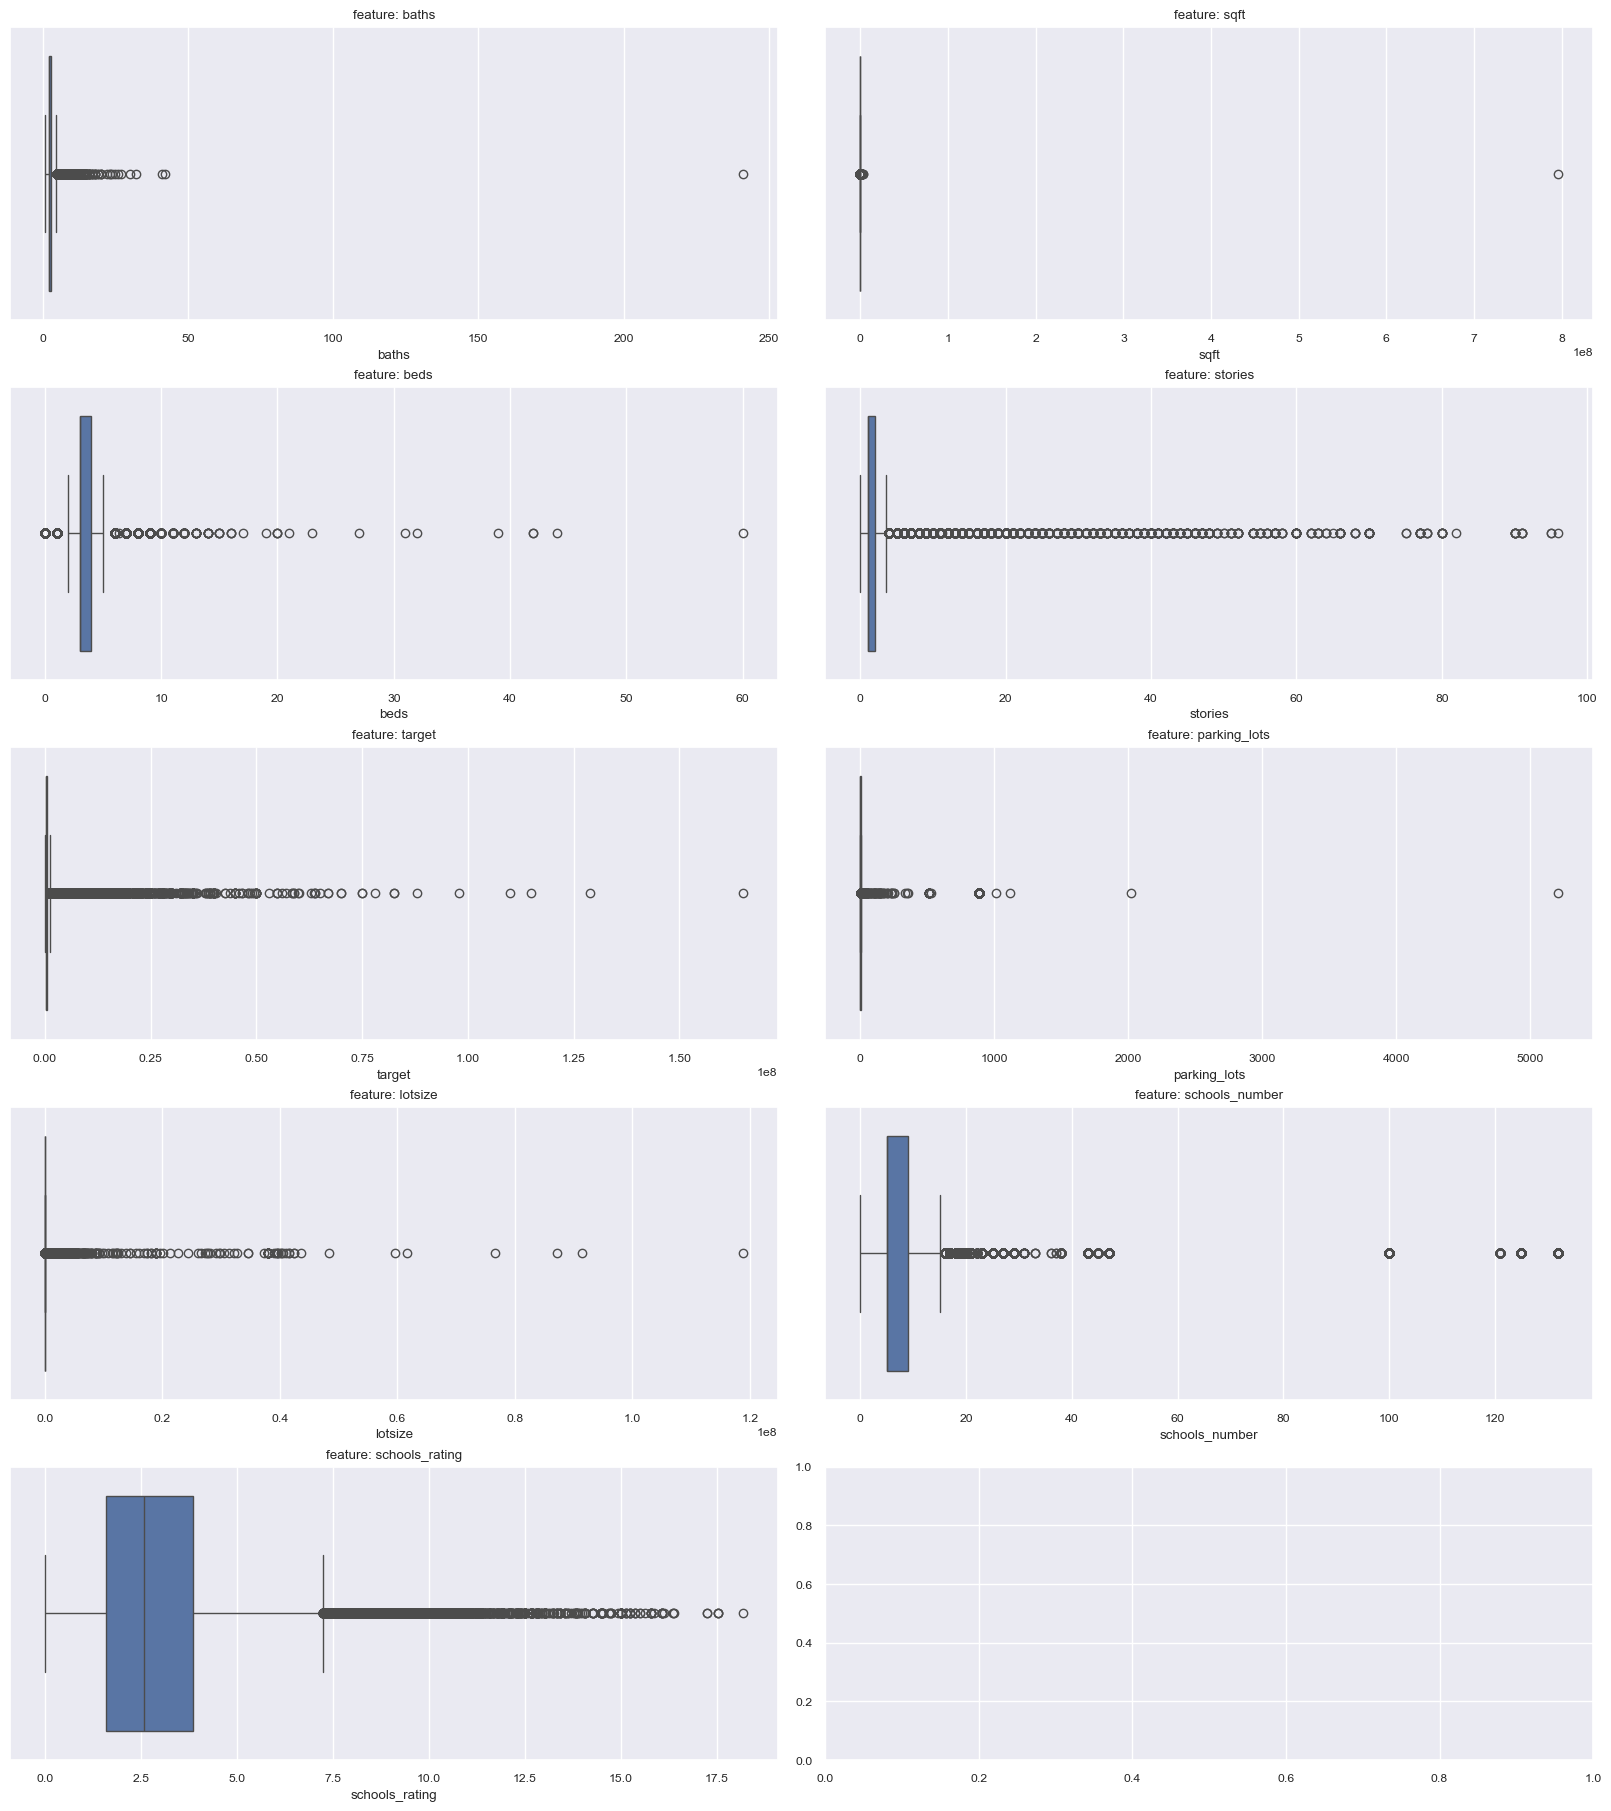

In [653]:
features_list_boxplot = ['baths', 'sqft', 'beds', 'stories', 'target', 'parking_lots', 'lotsize', 'schools_number', 'schools_rating']
multiplot(data, features_list_boxplot, 'target', mode='boxplot', scale=0.8)

Уберём очевидные выбросы:

In [654]:
data = data[data.baths < 50]
data = data[data.sqft < 1e+8]
data = data[data.parking_lots < 500]
data = data[data.lotsize < 0.5e+8]
data = data[data.schools_number < 30]
data = data[data.schools_rating < 16]

print(f'Размер датасета: {data.shape}')

Размер датасета: (280121, 23)


Посмотрим на диаграмму ещё раз:

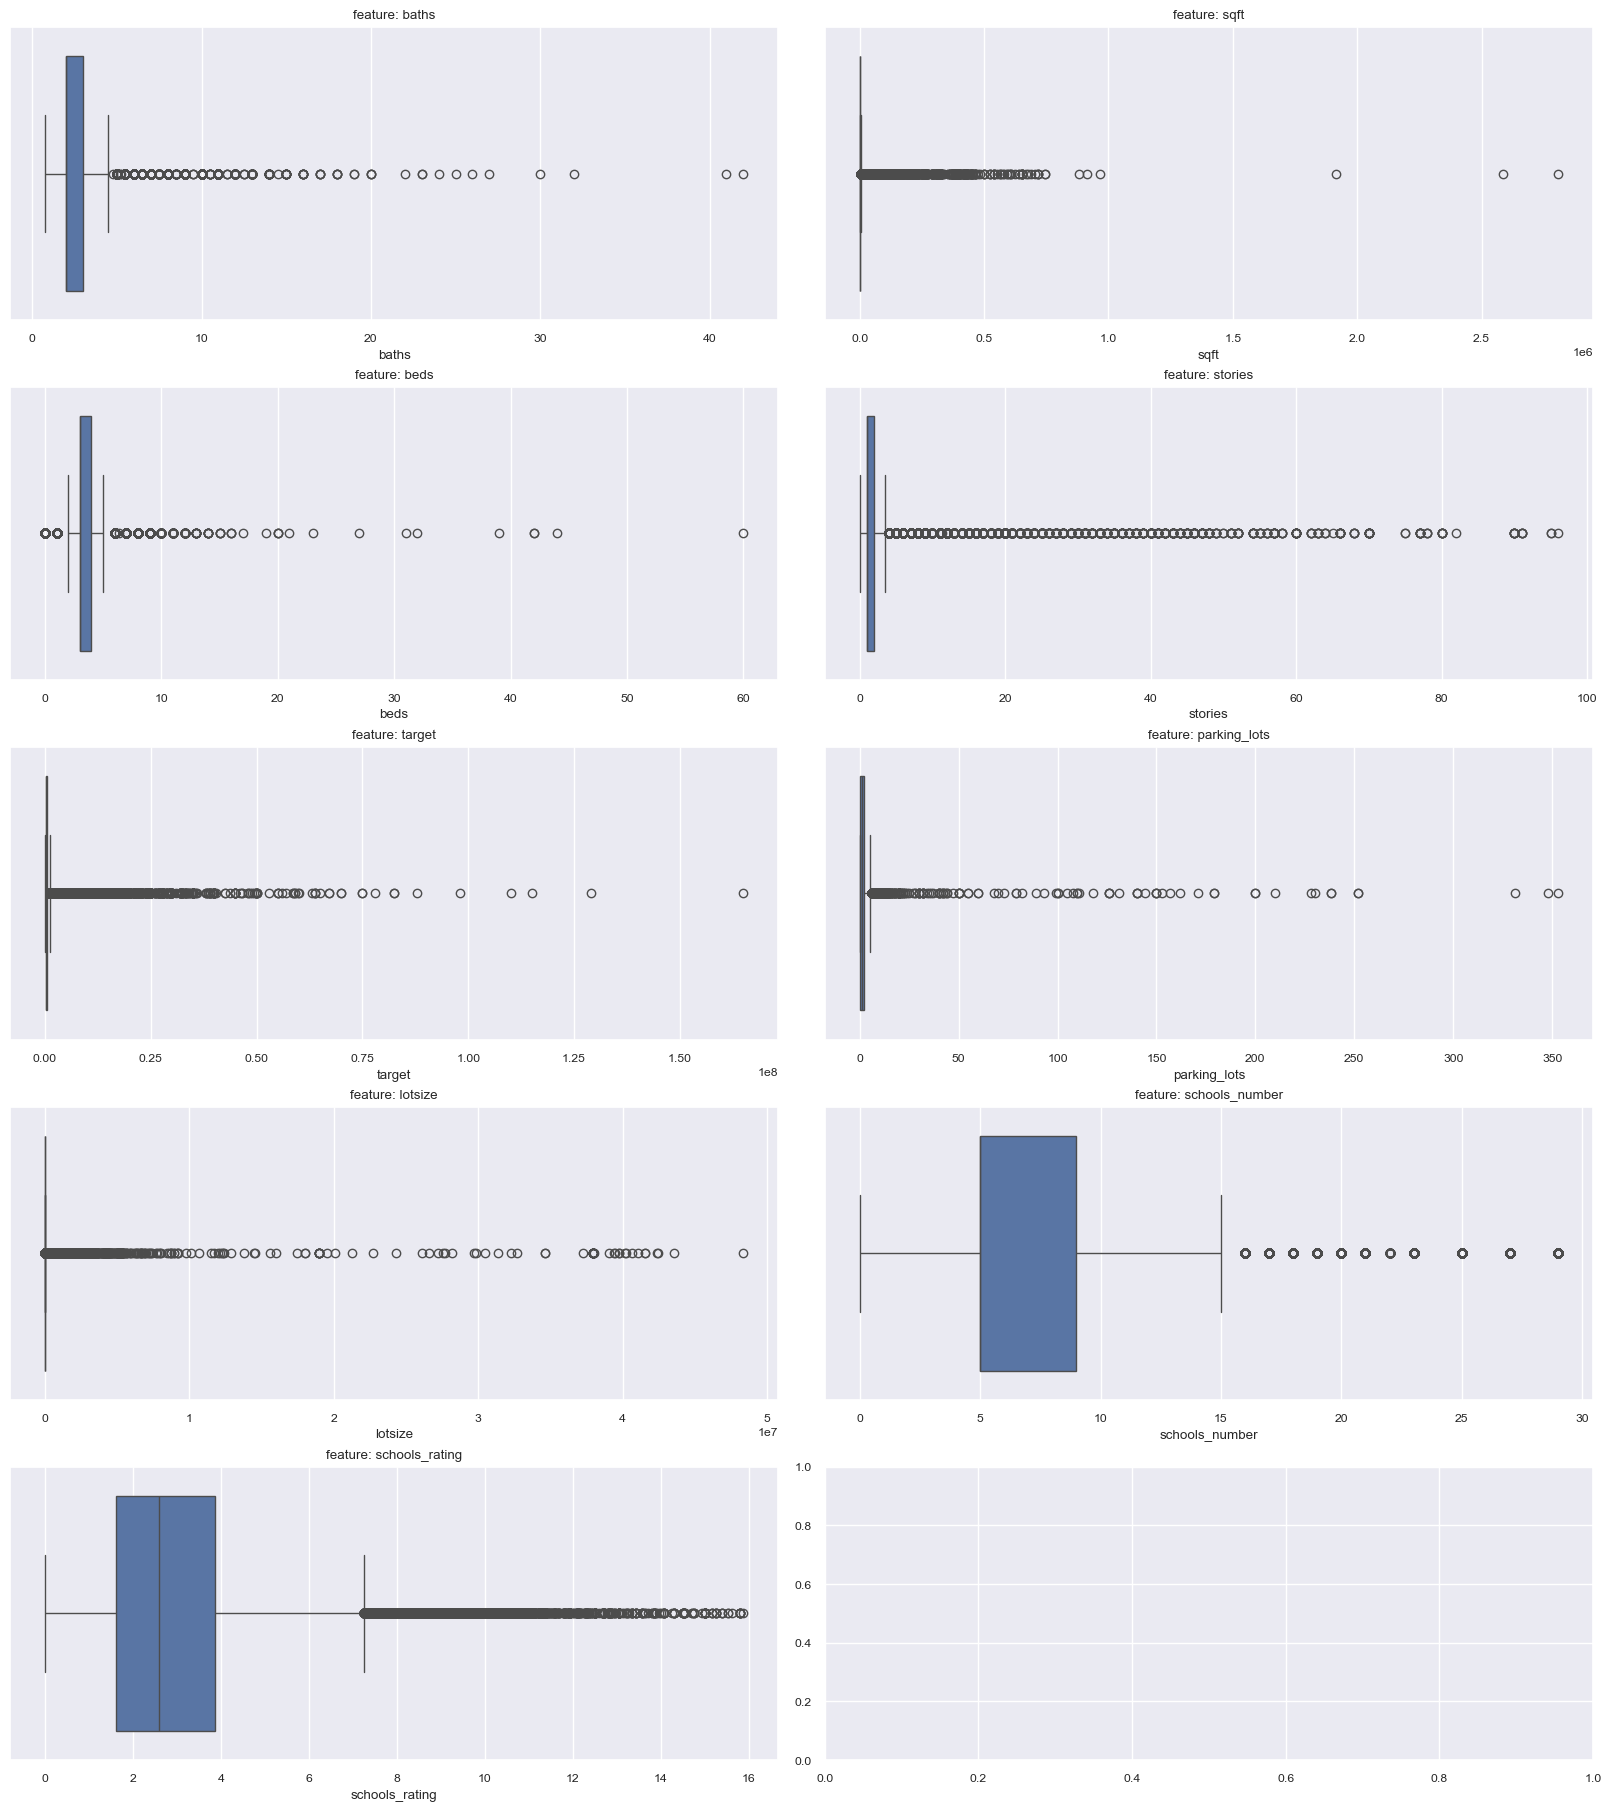

In [655]:
multiplot(data, features_list_boxplot, 'target', mode='boxplot', scale=0.8)

Ещё есть что очищать.

Можно с хорошей уверенностью предположить, что ванных комнат не может быть много больше чем спален. Отфильтруем значения по этому правилу:

In [656]:
mask_bath = (data.baths / data.beds > 2) & (data.baths > 2)
mask_bath.sum()

180

Таким образом, можно избавиться от неадекватных значений (например, 10 ванных комнат на 4 спальни). Удалим эти значения:

In [657]:
data = data[~mask_bath]

Давайте посмотрим сколько у нас данных, где количество спален и количество ванных комнат больше, например, 10, а также какие вообще значения есть:

In [658]:
print(f'Количество сделок, где у недвижимости больше 10 ванных: {data[data.baths > 10].shape[0]}')
print(f'Количество сделок, где у недвижимости больше 10 спален: {data[data.beds > 10].shape[0]}')
display(data[['baths', 'beds']].value_counts().nlargest(15))

Количество сделок, где у недвижимости больше 10 ванных: 246
Количество сделок, где у недвижимости больше 10 спален: 121


baths  beds
2.0    3.0     56676
       2.0     42050
1.5    3.0     29336
3.0    3.0     25043
       4.0     21701
2.0    4.0     13654
4.0    4.0      9307
2.5    3.0      6884
3.0    2.0      6699
4.0    3.0      6325
1.0    2.0      5302
       3.0      5010
       1.0      4276
3.0    5.0      4250
4.0    5.0      4247
dtype: int64

Крайне мало наблюдений, считаем их выбросами и удалим их:

In [659]:
data = data[data.baths < 10]
data = data[data.beds < 10]
print(f'Размер датасета: {data.shape}')

Размер датасета: (279393, 23)


Посмотрим сколько наблюдений признака ***parking_lots*** больше 10:

In [660]:
data[data.parking_lots > max_parking_lots].shape

(210, 23)

Крайне мало наблюдений, считаем их выбросами и удалим их:

In [661]:
data = data[data.parking_lots < 10]
print(f'Размер датасета: {data.shape}')

Размер датасета: (279102, 23)


Признак ***sqft***. Ограничим значение площади $10000\ кв.\ футов$. Это в несколько раз больше [средней площади](https://www.fool.com/the-ascent/mortgages/articles/how-big-is-your-home-here-is-the-average-home-size-by-state/). [Минимум](https://en.wikipedia.org/wiki/Microapartment#:~:text=In%20the%20United%20States%2C%20most,live%20together%20in%20one%20unit.) возьмём [150 кв. футов](https://worldpopulationreview.com/state-rankings/minimum-house-size-by-state).

In [662]:
data[(data.sqft > max_sqft) | (data.sqft < min_sqft)]

,status,private pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,...,target,Heating,Cooling,parking_lots,lotsize,parking_type,age,age_remodeled,schools_number,schools_rating
56,contingent,0,condo,drive,2.0,0,Southern Pines,0.0,28387,2.0,...,166500.0,none,other,0.0,0.0,none,25,999,18,2.003665
90,sale,0,coop,street,2.0,0,Kew Gardens,107250.0,11415,2.0,...,319000.0,none,other,0.0,32670.0,none,54,999,5,4.982968
136,sale,0,single_family_home,avenue,2.0,0,Bayside,109200.0,11361,3.0,...,270000.0,other,other,0.0,40075.2,none,60,999,6,7.531643
177,sale,0,single_family_home,court,2.0,1,Dallas,11598.0,75229,3.0,...,6599000.0,none,central,0.0,54014.4,none,13,15,8,1.871747
202,sale,0,coop,street,2.0,0,New York,225667.0,10031,2.0,...,455000.0,none,other,0.0,27007.2,none,66,999,5,0.957553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376515,sale,0,single_family_home,avenue,2.0,1,Winston Salem,0.0,27105,3.0,...,65000.0,forced air,central,2.0,7841.0,parking_lot,80,999,17,1.857767
376643,sale,0,single_family_home,street,1.0,0,Thomasville,0.0,31792,3.0,...,90000.0,none,other,0.0,0.0,none,999,999,13,4.599217
376701,sale,0,coop,avenue,2.0,0,Brooklyn,40558.0,11215,2.0,...,245000.0,none,other,0.0,11325.6,none,103,999,2,14.492754
376784,sale,0,coop,avenue,1.0,0,New York,21304.0,10011,1.0,...,499000.0,other,other,1.0,0.0,other,103,999,5,8.541667


Довольно мало наблюдений, удалим их:

In [663]:
data = data[(data.sqft > min_sqft) & (data.sqft < max_sqft)]
print(f'Размер датасета: {data.shape}')

Размер датасета: (276549, 23)


Признак ***lotsize***. Ограничим значение числом $1\ млн.\ кв.\ футов$.

In [664]:
data = data[data.lotsize < 1e+6]
print(f'Размер датасета: {data.shape}')

Размер датасета: (275770, 23)


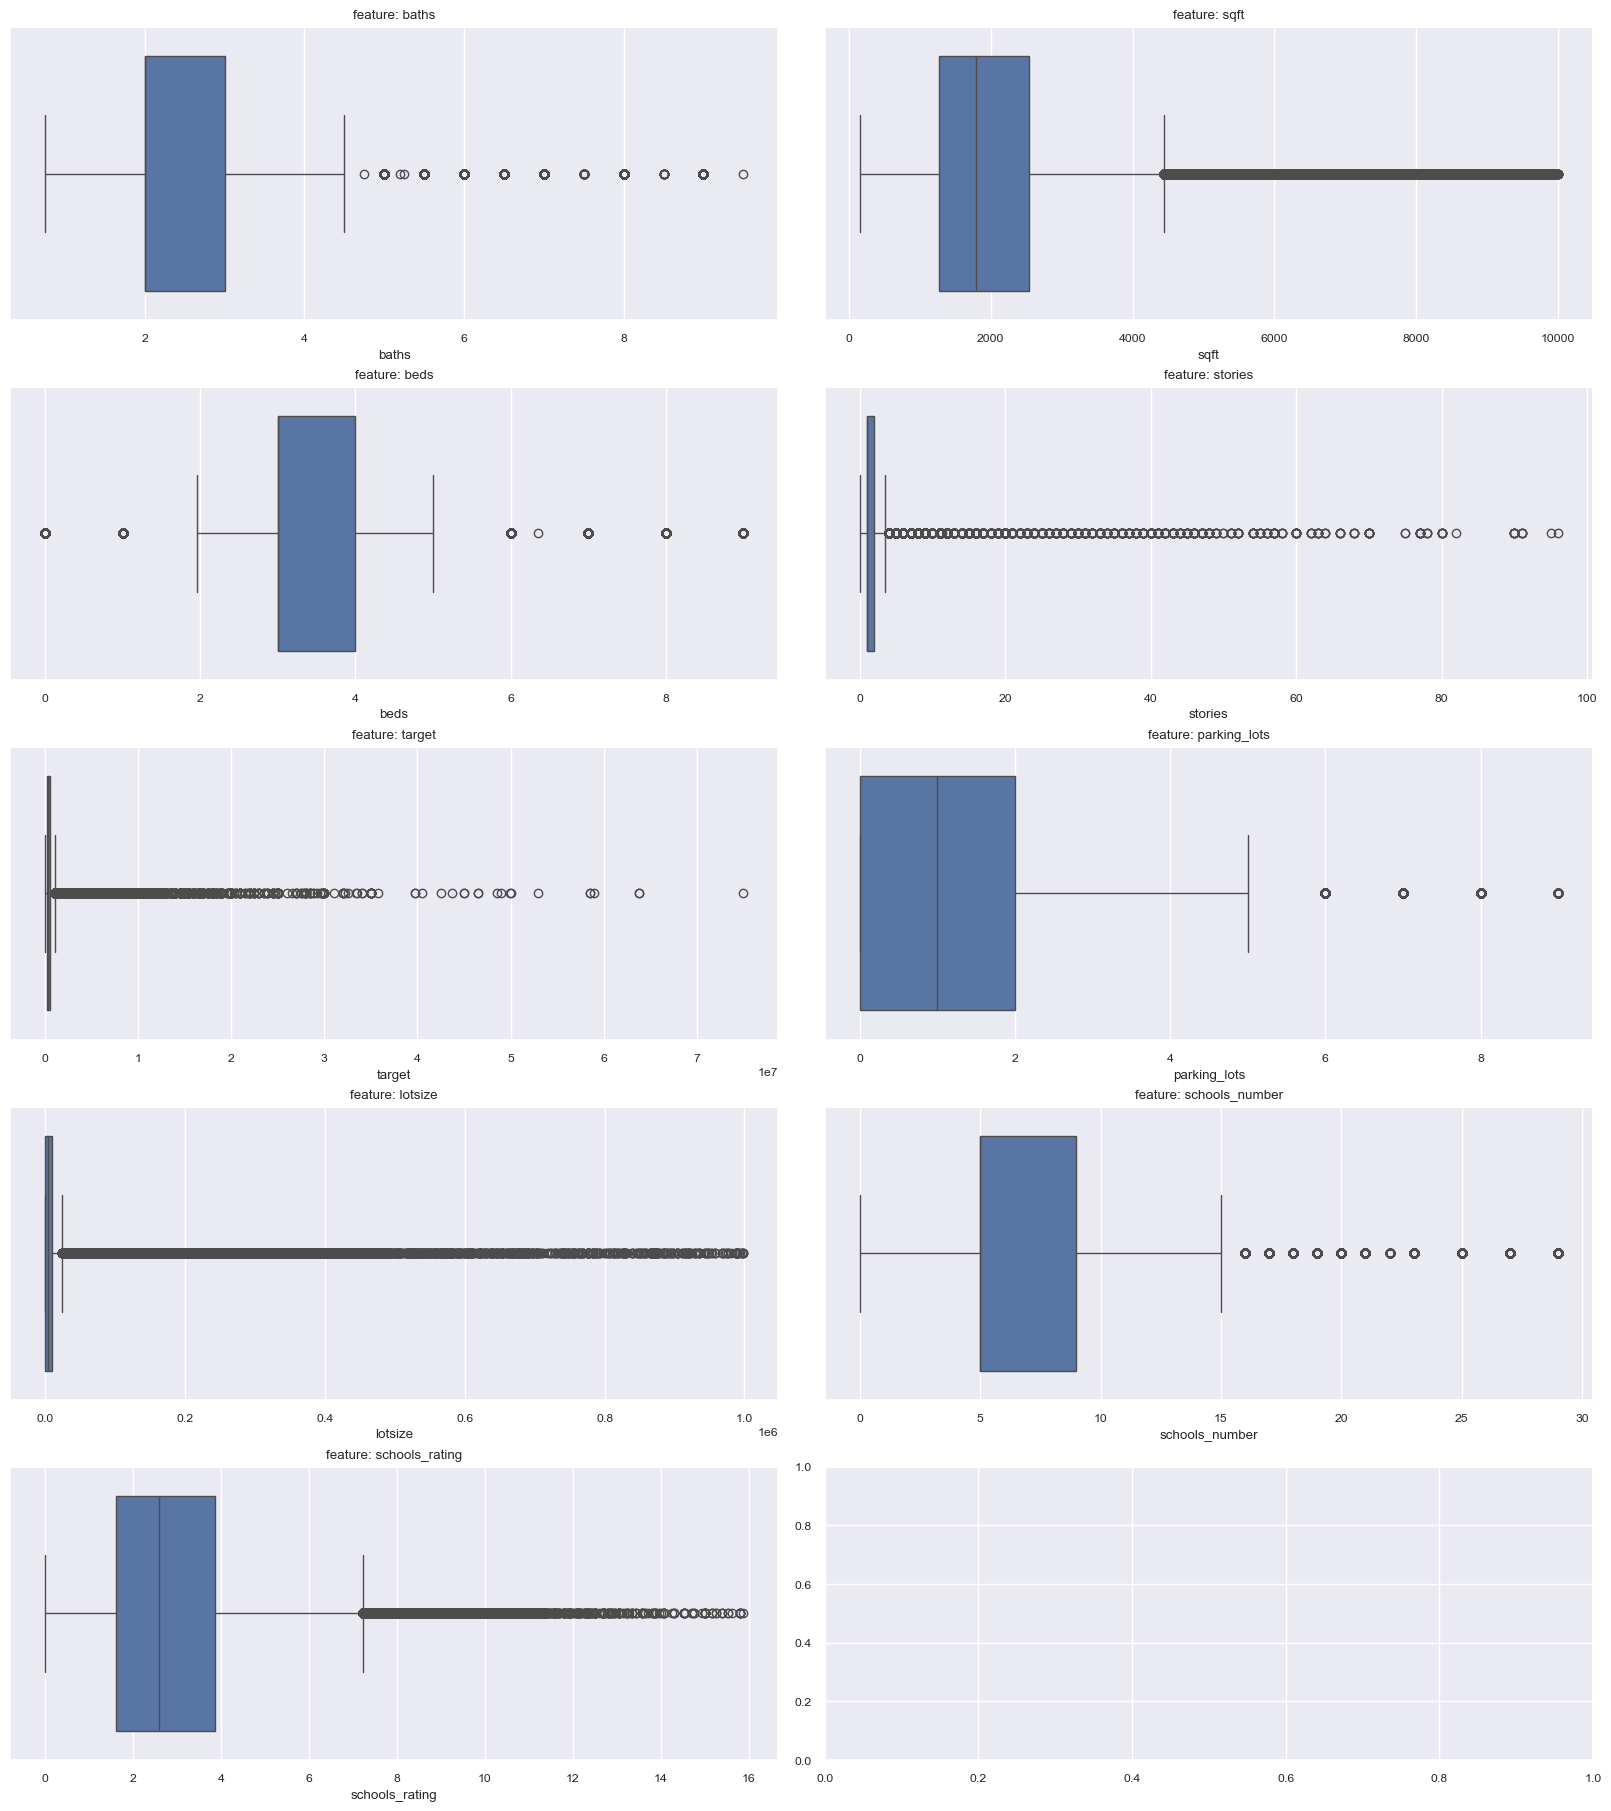

In [665]:
multiplot(data, features_list_boxplot, 'target', mode='boxplot', scale=0.8, bins=30)

Осталось разобраться с целевой переменная ***target***. Мы видим, что есть недвижимость ценой больше $70M. Очевидно, что подобные цены с точки зрения моделирования не очень подходят, поскольку подобные цены для наших данных можно считать выбросами:

In [666]:
data.target.describe()

count    2.757700e+05
mean     5.738087e+05
std      1.184777e+06
min      1.000000e+00
25%      2.149000e+05
50%      3.310000e+05
75%      5.600000e+05
max      7.500000e+07
Name: target, dtype: float64

Посмотрим на медианную цену:

In [667]:
target_median = data['target'].median()
target_median

331000.0

Давайте посмотроим гистограмму для цен до $4M вместе с медианой:

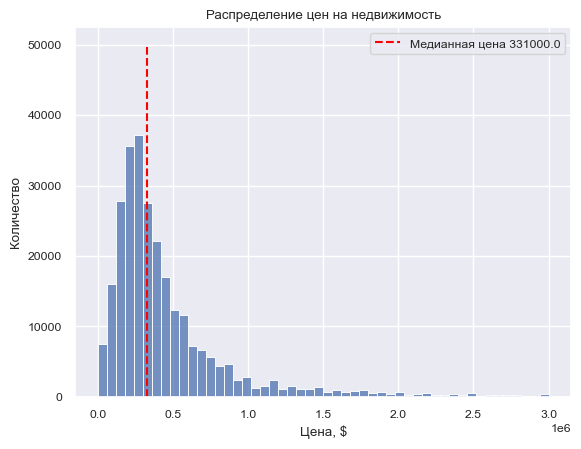

In [668]:
sns.histplot(x=data.target[data.target < 3e+6], bins=50)
plt.vlines(target_median, 0, 5e+4, colors='red', linestyles='dashed', label=f'Медианная цена {target_median}')
plt.title('Распределение цен на недвижимость')
plt.xlabel('Цена, $')
plt.ylabel('Количество')
plt.legend();

Посмотрим на количество наблюдений для цены больше $2M:

In [669]:
data[data.target > 3e+6].shape

(5059, 23)

Немного. Однако давайте сделаем так - переведём значения признака в лог. масштаб и сравним его с нормальным распределением:

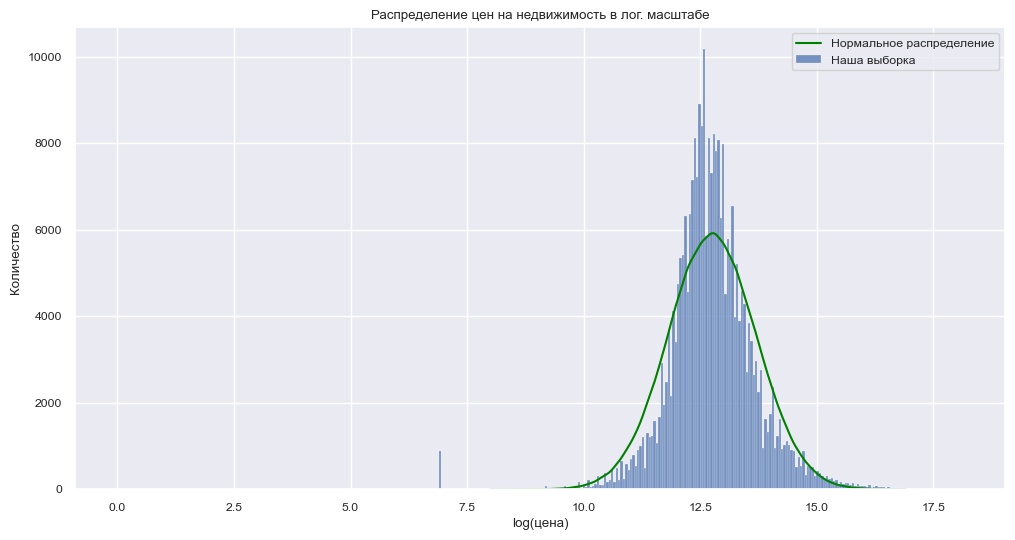

In [670]:
# логарифмируем целевую переменную
data['target_log'] = np.log(data['target'])

# создадим нормальное распредедение на тех же признаках
norm_data = np.random.normal(data['target_log'].mean(), data['target_log'].std(), data.shape[0])

# рисуем график
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(x=data.target_log, bins='scott')
sns.histplot(x=norm_data, bins='scott', alpha=0, fill=False, kde=True, color='green')
plt.title('Распределение цен на недвижимость в лог. масштабе')
plt.xlabel('log(цена)')
plt.ylabel('Количество')
plt.legend(labels=['Нормальное распределение', 'Наша выборка'])
plt.show();

Наш график похож на нормальный,  проведём стат. тест:

In [671]:
# тест Шапиро-Уилка

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально'

_, p = shapiro(data['target_log'])
print('p=%.5f' %p)

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.00000
Данные не распределены нормально


К сожалению, наше распределение не прошло тест, хоть и довольно похоже на нормальное распределение. Попробуем применить к нему метод Тьюки:

In [672]:
# мы сделали интервал больше чем 1.5, поскольку стандартный 1.5 интервал убирал слишком много значений
k = 2

quartile_1, quartile_3 = data.target_log.quantile(0.25), data.target_log.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound_q = quartile_1 - (k * iqr)
upper_bound_q = quartile_3 + (k * iqr)

lower_bound_q = np.exp(lower_bound_q)
upper_bound_q = np.exp(upper_bound_q)

print(f'Границы цен по методу Тьюки: нижняя граница = {lower_bound_q}, верхняя граница = {upper_bound_q}')

Границы цен по методу Тьюки: нижняя граница = 31647.047031250055, верхняя граница = 3802692.8667678093


In [673]:
# посмотрим какие штаты у нас в первой десятке датасета
data.state.value_counts().nlargest(10)

FL    84511
TX    63707
CA    17640
NC    15796
NY    12289
TN    12265
WA    10722
OH     8102
NV     7032
IL     6464
Name: state, dtype: int64

Давайте ограничимся этими значениями, выглядят они более-менее адекватно. Более того, можно примерно оценить по реальным цифрам: [тут](https://finance.yahoo.com/news/study-reveals-average-cost-per-195736142.html) можно посмотреть цену за на кв. фут. 
- Самые маленькие дома имеют площадь 150 кв. футов, что с учётом стоимости единицы площади в Техасе или Флориде (штаты больше всего представлены в данных) даёт нам минимальную цену около $40K.
- Если же возьмём самую высокую цену за единицу площади, то можно оценить размер дома в Калифорнии, где самая большая цена за кв. фут (кроме Гавайев): $\frac{3800000}{425} = 8941\ кв.\ футов$ (а это около $830\ м^2$ - довольно большой дом) при средней площади дома в [1800 кв. футов](https://www.fool.com/the-ascent/mortgages/articles/how-big-is-your-home-here-is-the-average-home-size-by-state/).

В целом, ограничение по цене можно объяснить и тем, что очень дешёвые и наоборот, очень дорогие дома имеют ценообразование несколько отличное от "обычных" домов. Тем более что подобных наблюдений около 2%:

In [674]:
data[(data.target < lower_bound_q) | (data.target > upper_bound_q)].shape

(6309, 24)

Удалим их:

In [675]:
data = data[(data.target > lower_bound_q) & (data.target < upper_bound_q)]
print(f'Размер датасета: {data.shape}')

data = data.drop('target_log', axis=1)

Размер датасета: (269461, 24)


Сделаем подобные преобразования для признаков ***sqft*** и ***school_rating***:

In [676]:
# логарифмируем наши признаки
data['sqft_log'] = np.log(data.sqft)
data['schools_rating_log'] = np.log(data.schools_rating + 1)

p=0.00000
Данные не распределены нормально
Количество удалённых наблюдений: 2473


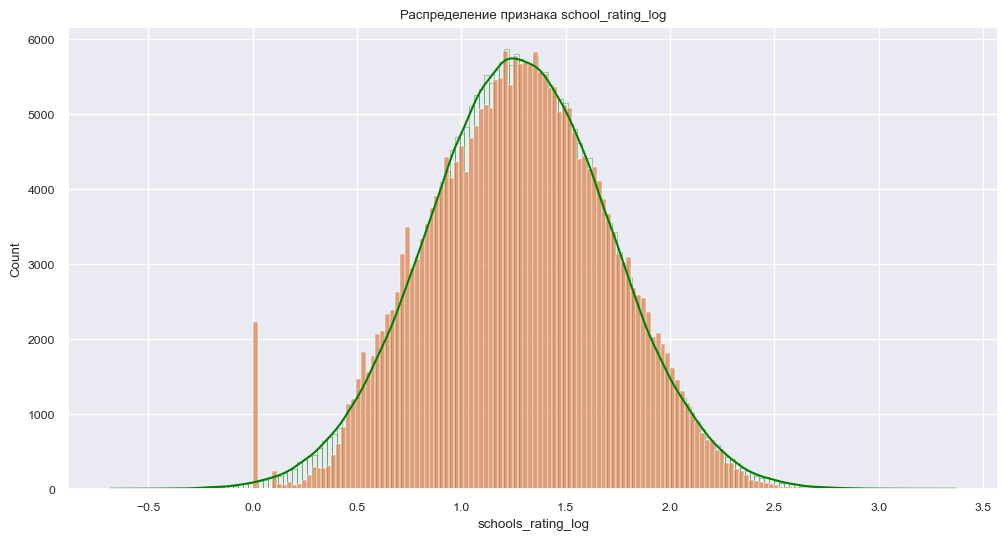

In [677]:
# построим гистограмму для нашего признака, а таже нормальное распределение на тех же параметрах
norm_data = np.random.normal(data.schools_rating_log.mean(), data.schools_rating_log.std(), data.shape[0])
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(x=norm_data, bins='scott', alpha=0.5, fill=False, kde=True, color='green');
sns.histplot(x=data.schools_rating_log, bins='scott')
plt.title('Распределение признака school_rating_log');

# тест Шапиро-Уилка
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально'
_, p = shapiro(np.log(data.schools_rating + 1))
print('p=%.5f' %p)
if p > alpha:
	print(H0)
else:
	print(Ha)

# удаляем выбросы
outliers, data = outliers_iqr(data, 'schools_rating_log')
print(f'Количество удалённых наблюдений: {outliers.shape[0]}')

p=0.00000
Данные не распределены нормально
Количество удалённых наблюдений: 25


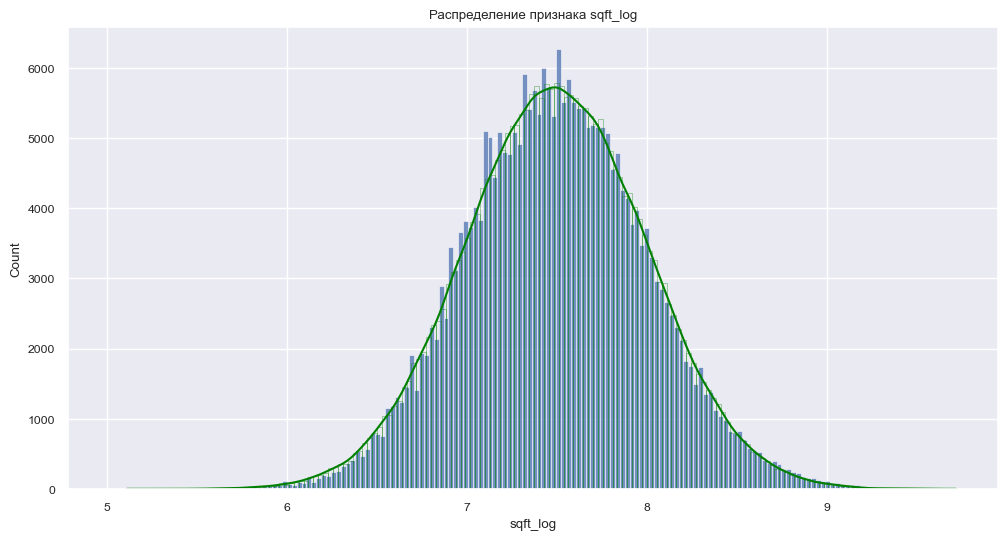

In [678]:
# построим гистограмму для нашего признака, а таже нормальное распределение на тех же параметрах
norm_data = np.random.normal(data.sqft_log.mean(), data.sqft_log.std(), data.shape[0])
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(x=data.sqft_log, bins='scott')
sns.histplot(x=norm_data, bins='scott', alpha=0.5, fill=False, kde=True, color='green');
plt.title('Распределение признака sqft_log');

# тест Шапиро-Уилка
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально'
_, p = shapiro(np.log(data.schools_rating + 1))
print('p=%.5f' %p)
if p > alpha:
	print(H0)
else:
	print(Ha)

# удаляем выбросы
outliers, data = outliers_iqr(data, 'schools_rating_log')
print(f'Количество удалённых наблюдений: {outliers.shape[0]}')

In [679]:
# удалим уже ненужные столбцы
data = data.drop(['sqft_log', 'schools_rating_log'], axis=1)

Посмотрим на признаки в разрезе цены:

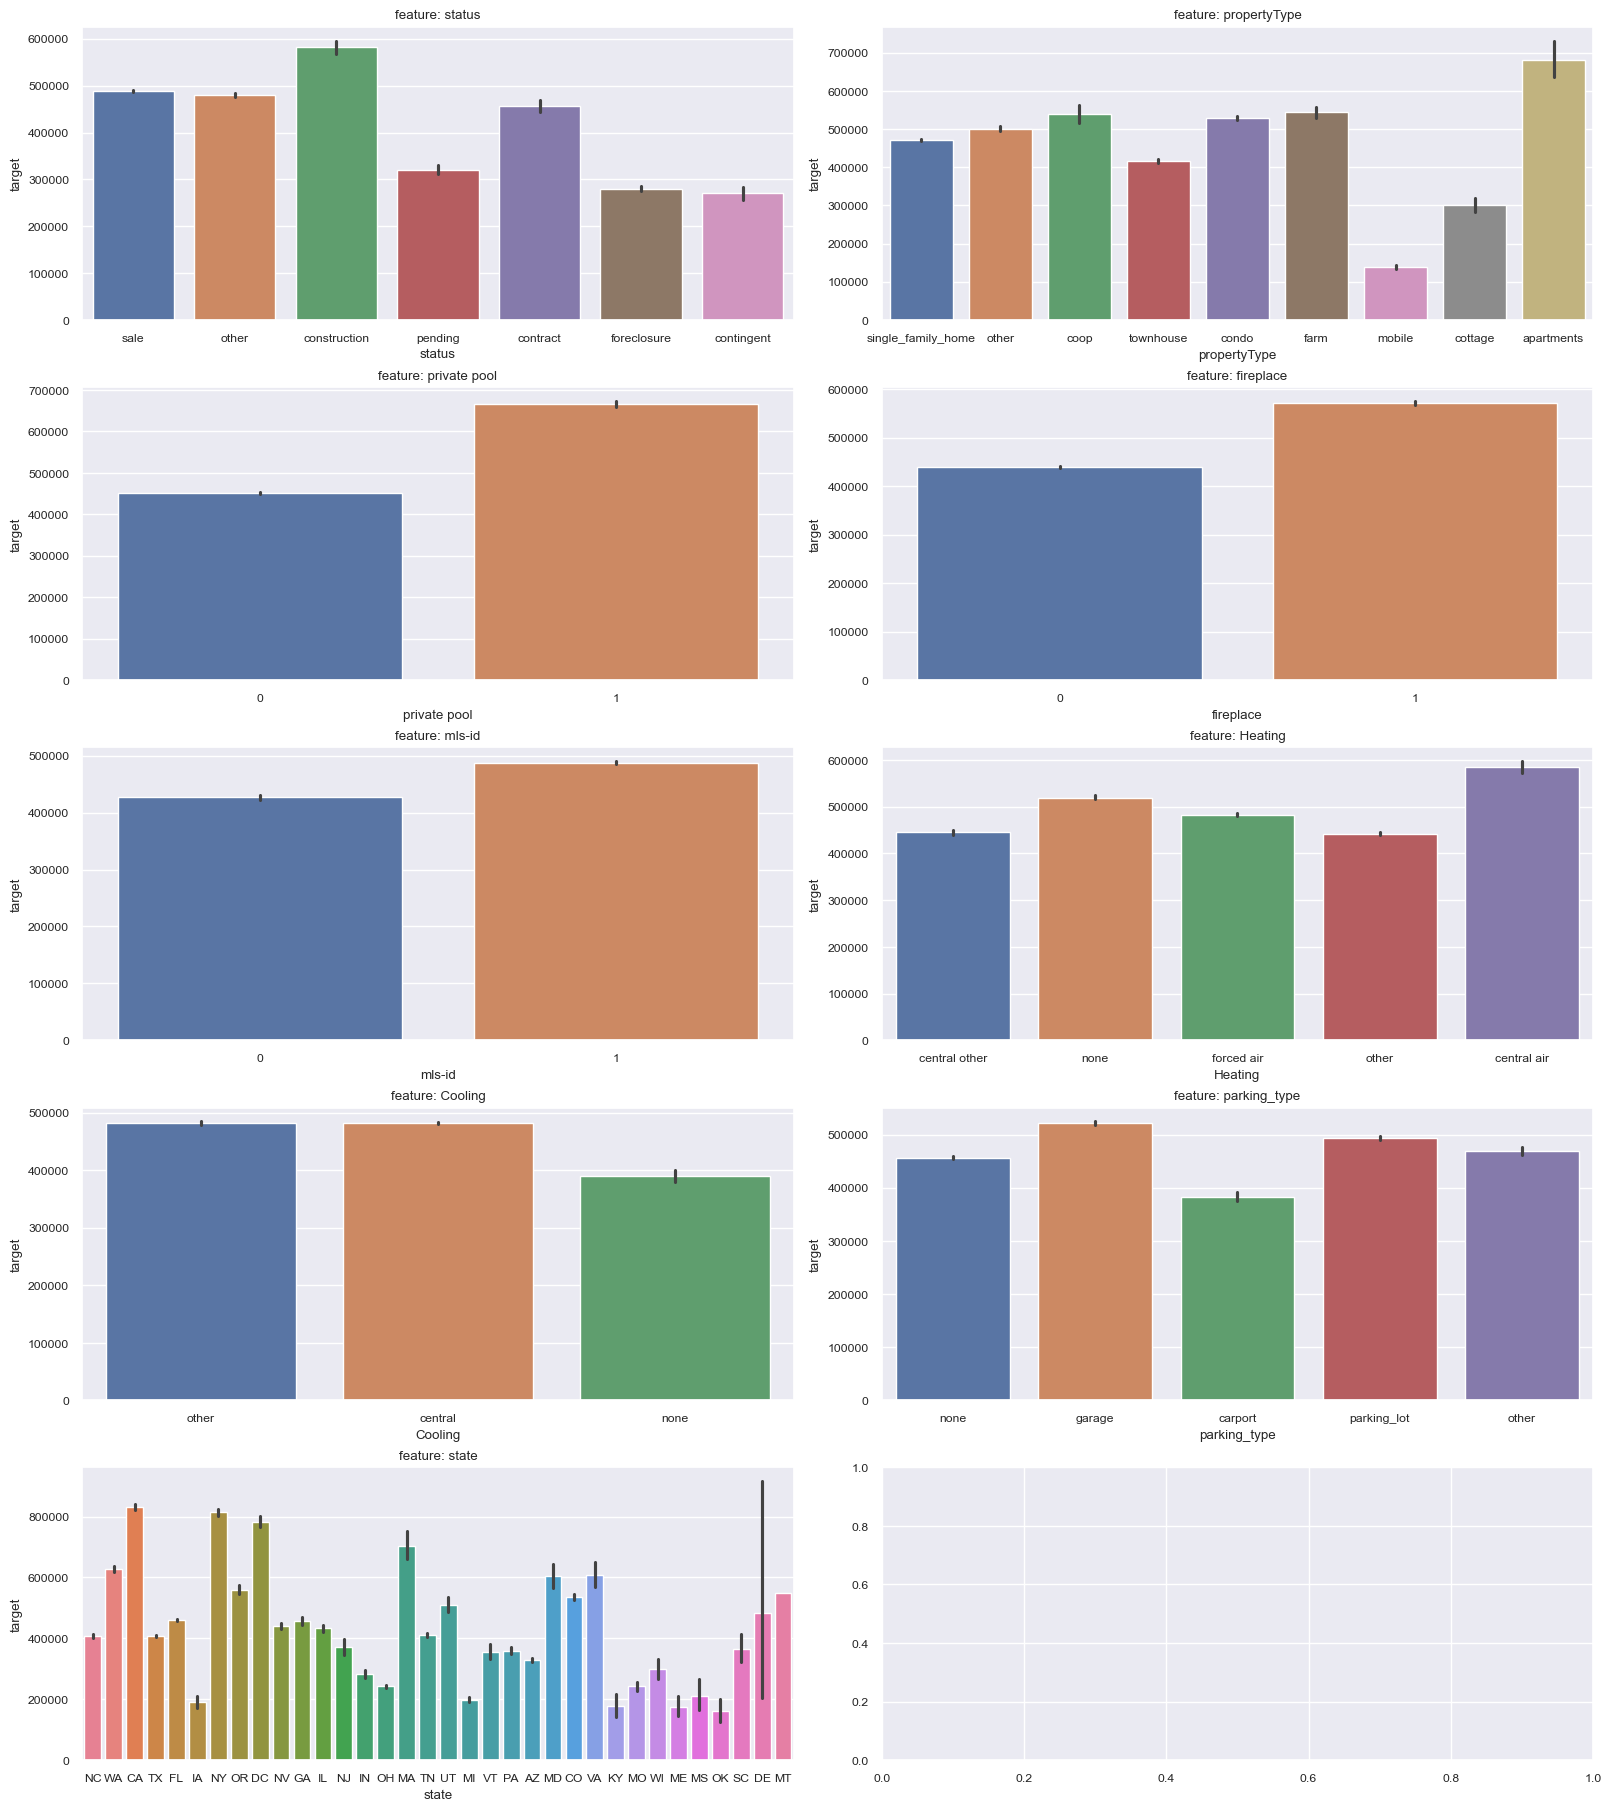

In [680]:
features_list_barplot = ['status', 'propertyType', 'private pool', 'fireplace', 'mls-id', 'Heating', 'Cooling', 'parking_type', 'state']
multiplot(data, features_list_barplot, 'target', mode='barplot', scale=0.8)

Проверим, есть ли разница статистическая разница между ценами на дома, которые находятся в системе мультилистинга, и ценами на дома, которых в этой системе нет. Будем использовать независимый Т-тест:

In [681]:
H0 = 'Нет значимой статистической разницы.'
Ha = 'Есть значимая статистическая разница.'

_, p = ttest_ind(data.loc[data['mls-id'] == 1, 'target'], data.loc[data['mls-id'] == 0, 'target'])
if p > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H0} p = {p}')
else:
    print(f'Мы отвергаем нулевую гипотезу. {Ha} p = {p}')

Мы отвергаем нулевую гипотезу. Есть значимая статистическая разница. p = 2.1131884107123239e-103


Проверим, есть ли разница статистическая разница между ценами на дом разными типами кондиционирования:

In [682]:
H0 = 'Нет значимой статистической разницы.'
Ha = 'Есть значимая статистическая разница.'

_, p = ttest_ind(data.loc[data['Cooling'] == 'central', 'target'], data.loc[data['Cooling'] == 'other', 'target'])
if p > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H0} p = {p}')
else:
    print(f'Мы отвергаем нулевую гипотезу. {Ha} p = {p}')

Мы не можем отвергнуть нулевую гипотезу. Нет значимой статистической разницы. p = 0.8704776746308183


Объединим эти признаки и посмотрим на график:

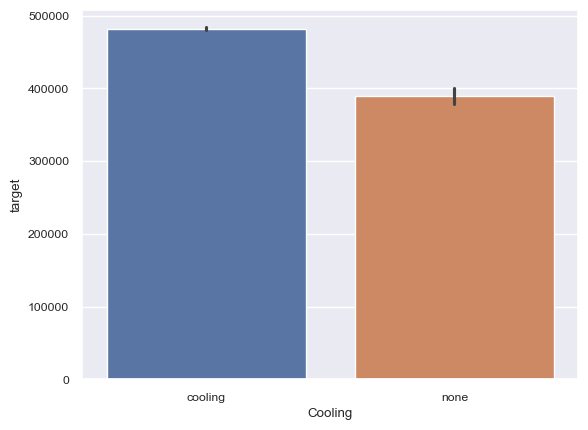

In [683]:
data.Cooling[data.Cooling != 'none'] = 'cooling'
data.Cooling.value_counts()
sns.barplot(x=data.Cooling, y=data.target, hue=data.Cooling);

Вполне можно утверждать, что есть зависимость целевого признака от наших категорий.

Посмотрим на гистограммы:

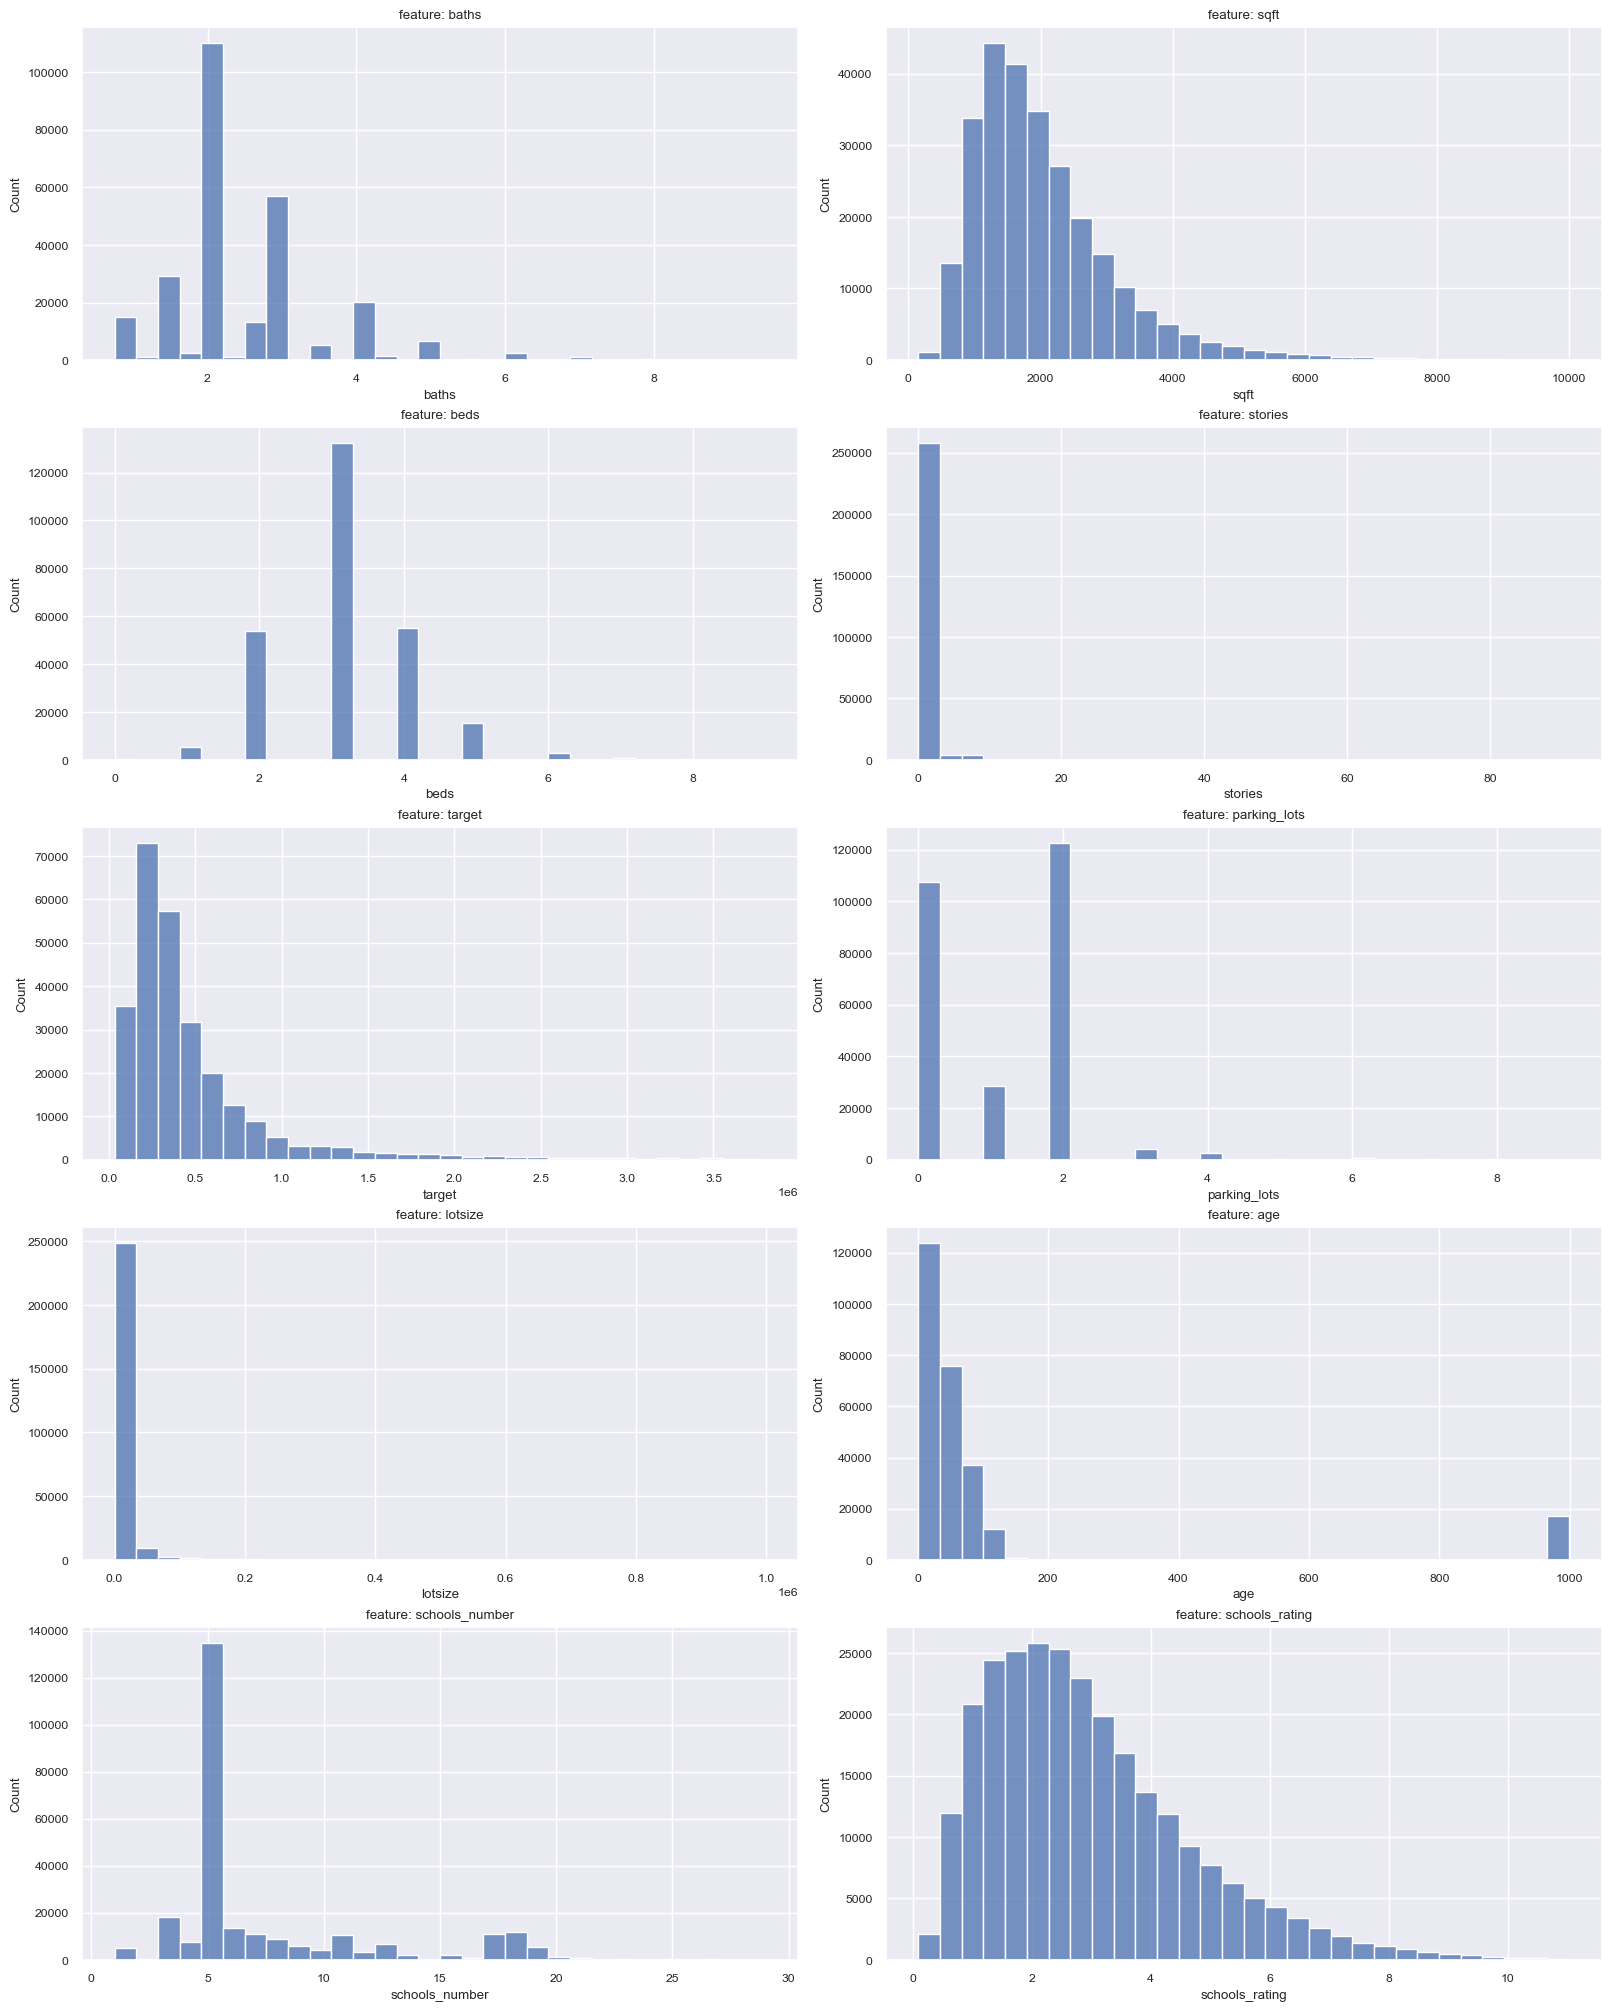

In [684]:
features_list_histplot = ['baths', 'sqft', 'beds', 'stories', 'target', 'parking_lots', 'lotsize', 'age', 'schools_number', 'schools_rating']
multiplot(data, features_list_histplot, 'target', mode='histplot', scale=0.8, bins=30)

Посмотрим на диаграммы разброса:

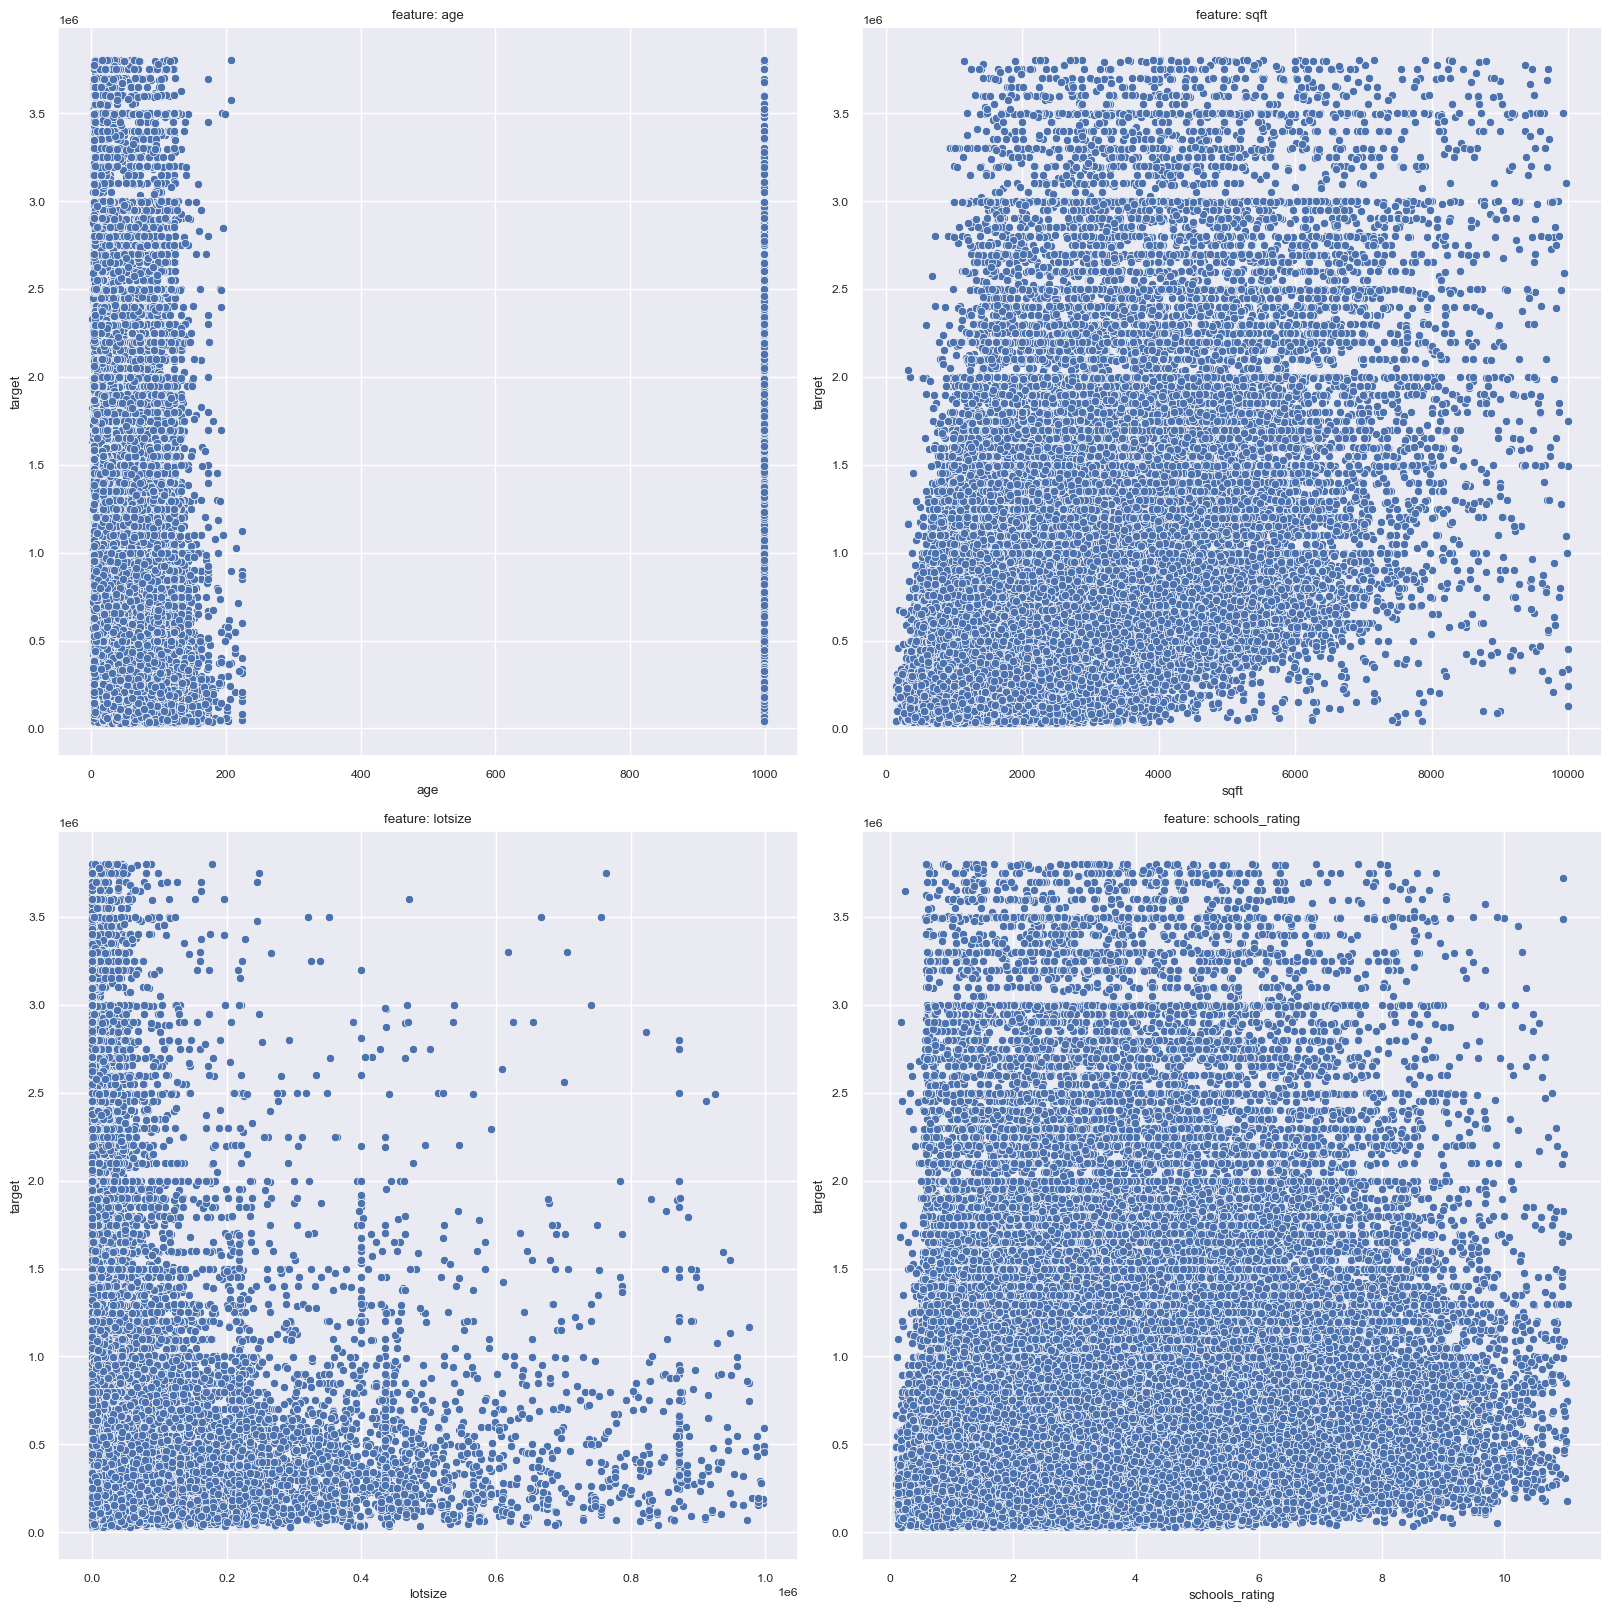

In [685]:
multiplot(data, ['age', 'sqft', 'lotsize', 'schools_rating'], 'target', mode='scatterplot', height=4, scale=0.8)

Как мы видим, из этих графиков довольно непросто угадать какую либо зависимость. Можно предположить положительную крреляцию целевого признака с ***sqft*** и ***school_rating***. Хотя с другой стороны подобное поведение было ожидаемо: один и тот же дом в Алабаме и в Калифорнии будет стоить совершенно по-разному.

Уберём выбросы с помощью изолирующего леса (немного улучшает метрику):

In [686]:
from sklearn.ensemble import IsolationForest

# выделим признаки, у которых надо найти выбросы
outliers_features = ['sqft', 'lotsize', 'schools_rating', 'stories', 'target']
y = data['target']
X = data[outliers_features]
total = data.shape[0]

iso = IsolationForest(
    n_estimators=150,
    contamination=0.05,
    bootstrap=True,    
    n_jobs=-1,
    random_state=random_state
)
iso.fit(X.values)
y_predicted = iso.predict(X.values)
mask = y_predicted != -1

print(f'Удалено строк с помощью изолирующего леса: {total - mask.sum()}')
data = data[mask]
print(f'Размер датасета: {data.shape[0]}')

Удалено строк с помощью изолирующего леса: 13349
Размер датасета: 253614


***
### Создание признаков

Теперь мы соединим наш датасет с другим, где добавлены сведения о местоположении (корректное название города, координаты, население и плотность населения). Таже был ещё проведён парсинг по конкретным адресам, но к сожалению, точность геосервиса хромает, поэтому не будем использовать эти данные.

Главной проблемой геопрасинга оказалось то, что многие города в датасете по факту оказались:
- локальными пригородами,
- локальными названиями районов мегаполисов,
- замкнутыми сообществами,
- и тому подобное.

Поэтому удалим города, которые упоминаются в датасете менее 10 раз (это около 1% всего датасета), удалим города, для которых сложно спарсить информацию. Также переименуем часть городов в соотвествии с их положением и соседством. Объединим таблицы в одну, в которой будут следующие признаки:
* координаты города;
* население;
* плотность населения.

Для начала проверим почтовые индексы на корректность:

In [687]:
data['zipcode_check'] = pd.to_numeric(data['zipcode'], errors='coerce', downcast='integer')
mask_zipcode = data['zipcode_check'].isna()

data = data.drop('zipcode_check', axis=1)

data.loc[mask_zipcode, 'zipcode']

3654      27606-1626
5192      27607-6632
7155      27705-3261
7545      27603-2692
11066     27613-8607
             ...    
361312    27603-2089
363246    27610-5617
364001    27615-3876
365075    77015-2522
365763    27615-6225
Name: zipcode, Length: 204, dtype: object

Ага, часть индексов некорректна для запроса. Поэтому для них возьмём только первые пять символов:

In [688]:
data['zipcode'] = data['zipcode'].str[:5]

Сделаем предположение, что цена имеет определенную зависимость от самого города (населения, плотности населения), так и от соседних городов (расстояния и времени в пути до самого крупного города штата).

Убедимся, что все индексы состоят из 5-ти цифр:

In [689]:
data['zip_length'] = data['zipcode'].apply(lambda x: len(x))

mask_zipcode = data['zip_length'] != 5
print(f'Количество некорректных индексов: {mask_zipcode.sum()}')
data[mask_zipcode].head()

Количество некорректных индексов: 658


,status,private pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,...,Heating,Cooling,parking_lots,lotsize,parking_type,age,age_remodeled,schools_number,schools_rating,zip_length
69,sale,0,single_family_home,court,2.0,0,Lakewood,2272.0,8701,2.0,...,other,cooling,1.0,4983.0,other,24,999,17,1.554279,4
129,construction,0,single_family_home,street,3.0,0,Worcester,1700.0,1604,3.0,...,forced air,cooling,2.0,2613.0,garage,4,999,3,0.857558,4
344,sale,0,single_family_home,lane,1.0,0,Swanton,1834.0,5488,3.0,...,other,cooling,2.0,16117.0,garage,20,999,13,1.902673,4
920,sale,0,single_family_home,road,3.0,0,Enosburg,2843.0,5450,3.0,...,other,cooling,2.0,46174.0,garage,14,999,8,1.288515,4
928,sale,0,single_family_home,drive,2.5,0,Essex,3083.0,5452,4.0,...,other,cooling,2.0,20038.0,garage,34,999,19,4.143691,4


Сколько символов в оставшихся "неправильных" индексах:

In [690]:
data.loc[data['zip_length'] != 5, 'zip_length'].unique()

array([4, 2], dtype=int64)

Ага, наши "неверные" индексы имеют три различные длины. При внимательном рассмотрении, можно увидеть, что длина $4$ получилась потому, что в начале индекса был $0$. Вернём его на место:

In [691]:
data.loc[data['zip_length'] == 4, 'zipcode'] = '0' + data.loc[data['zip_length'] == 4, 'zipcode']

Удалим индексы размером $2$ и контрольный столбец:

In [692]:
data = data[data['zip_length'] == 5]

data = data.drop('zip_length', axis=1)

Также проверим корректность обозначений штатов и некорректные удалим:

In [693]:
# список аббревиатур штатов
correct_state_letters = list(us_state_to_abbrev.values())

# приведём все в верхний регистр
data['state'] = data['state'].str.upper()

mask_states = data['state'].apply(lambda x: False if x in correct_state_letters else True)
data = data[~mask_states]
print(f'Количество некорректных обозначений штатов: {mask_states.sum()}')

Количество некорректных обозначений штатов: 0


Загрузим спарсенный датафрейм и объединим таблицы, добавив следующие признаки:
- *lat* - широта города
- *lng* - долгота города
- *population* - количество населения;
- *density* - плотность населения;

Как указывалось ранее, что в присоединяемой таблице проставлены более корректные названия городов, которые был определены по индексу с помощью парсинга:

In [694]:
# сбросим индексы
data = data.reset_index()

data_city_info = pd.read_csv('data/data_city_info.csv')
data_city_info = data_city_info[['index', 'city', 'lat', 'lng', 'population', 'density']]

# объединим таблицы
data = data.merge(data_city_info, how='left', on='index')

# уберём получившиеся пропуски, если они есть (если не нашли данные по городу)
data = data[~data.city_y.isna()]
print(f'Количество некорректных названий городов в изначальных данных: {data.city_y.isna().sum()}')

# уберём ненужный столбец с городом и переименуем оставшийся
data = data.drop(['city_x', 'index'], axis=1)
data = data.rename(columns={'city_y':'city'})

Количество некорректных названий городов в изначальных данных: 0


Уберём пропущенные значения:

In [695]:
# удалим пропуски по тем городам, по которым не удалось спарсить всю информацию
data = data.dropna(subset=['lat', 'lng', 'population', 'density'])
print(f'Размер датасета: {data.shape[0]}')

Размер датасета: 249109


Cпарсим с википедии [страничку](https://en.wikipedia.org/wiki/List_of_largest_cities_of_U.S._states_and_territories_by_population) с крупнейшими городами по штатам и укажем для каждого штата крупнейший город::

In [696]:
# # пробуем спарсить таблицу
# html = wp.page('List_of_largest_cities_of_U.S._states_and_territories_by_population').html().encode('UTF-8')
# try: 
#     df_largest_cities = pd.read_html(html)[1]
# except IndexError:
#     df_largest_cities = pd.read_html(html)[0]

# # преобразуем её в нужный вид
# df_largest_cities.columns = df_largest_cities.columns.get_level_values(0)
# df_largest_cities = df_largest_cities[['State, federal district, or territory', 'Most populous']]
# df_largest_cities.columns = ['state', 'largest_city', 'state_letters']

# # сменим обозначения штатов с полного названия на аббревиатуру
# df_largest_cities['state_letters'] = df_largest_cities['state'].map(us_state_to_abbrev)

# # исправим ошибки парсинга
# df_largest_cities['state'] = df_largest_cities['state'].str.replace(r'[\d]', '', regex=True)
# df_largest_cities['largest_city'] = df_largest_cities['largest_city'].str.replace(r'[\d]', '', regex=True)
# df_largest_cities.state_letters.iloc[22] = 'MD'
# df_largest_cities.state_letters.iloc[50] = 'VI'
# df_largest_cities['largest_city'] = df_largest_cities['largest_city'].str.replace(', D.C.', '')

# # запишем датасет
# # df_largest_cities.to_csv('data/us_largest_cities_by_states.csv')

# # создадим словарь чтобы создать новый столбец
# largest_city_dict = df_largest_cities[['state_letters', 'largest_city']].set_index('state_letters').to_dict()
# largest_city_dict = largest_city_dict['largest_city']

# # создадим нужный столбец
# data['largest_city'] = data['state'].map(largest_city_dict)

Подгрузим ранее спарсенные данные по крупнейшим городам отдельных штатов:

In [697]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------
# загружаем данные из ранее спарсенного датафрейма
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

us_largest_cities = pd.read_csv('data/us_largest_cities_by_states.csv', index_col='state_letters', usecols=['largest_city', 'state_letters'])
us_largest_cities = us_largest_cities.to_dict()
us_largest_cities = us_largest_cities['largest_city']
data['largest_city'] = data['state'].map(us_largest_cities)

Составим уникальные пары городов, между которыми нужно найти расстояние:

In [698]:
# приведём строку в нужный для парсера вид
data['city_pair'] = data['city'].str.lower() + ',' + data['state'] + '_' + data['largest_city'].str.lower() + ',' + data['state']
# заменим пробелы спецcимволом и сделаем список
data['city_pair'] = data['city_pair'].str.replace(' ', '%20').str.split('_')
# преобразуем его в кортеж
data['city_pair'] = data['city_pair'].apply(tuple)
# получим наши уникальные пары, не учитываем пару, если город и так является крупнейшим в штате
city_pairs = np.unique(data.loc[data.city.str.lower() != data.largest_city.str.lower(), 'city_pair'].values)

Узнаем расстояние и время поездки между городами:

In [699]:
# так можно запустить парсер
# distance_dict, time_dict, issues_dict = bing_distance_time_parser(city_pairs)

# но не будем запускать парсер, возьмём данные из ранее спарсенного датафрейма и объединим таблицы
distance_time = pd.read_csv('data/distance&time_parsed_1.csv')
data['city_pair'] = data['city_pair'].astype(str)
data = data.merge(distance_time, how='left', left_on='city_pair', right_on='city_pair')

Поправим ошибки парсинга. Их очень мало, поэтому сделаем напрямую:

In [700]:
# этот объект не находится в США - удалим его
data = data[data.city_pair != ('quito%20ecuador,NY', 'new%20york%20city,NY')]

# исправим некоторые значения
fixes_dict = {
    ('point%20charlotte,FL', 'jacksonville,FL'): ('port%20charlotte,FL', 'jacksonville,FL'),
    ('barrington,CA', 'los%20angeles,CA'): ('los%20angeles,CA', 'los%20angeles,CA'),
    ('brookside%20vl,TX', 'houston,TX'): ('houston,TX', 'houston,TX'),
    ('mdale,NY', 'new%20york%20city,NY'): ('syracuse,NY', 'new%20york%20city,NY'),
    ('pacific,WA', 'seattle,WA'): ('tacoma,WA', 'seattle,WA'),
    ('panama%20city%20beach,FL', 'jacksonville,FL'): ('panama%20city,FL', 'jacksonville,FL'),
    ('saintdman,NC', 'charlotte,NC'): ('fayetteville,NC', 'charlotte,NC'),
    ('westover%20hills,TX', 'houston,TX'): ('fort%20worth,TX', 'houston,TX')
}
data['city_pair'] = data['city_pair'].apply(lambda x: fixes_dict[x] if x in fixes_dict.keys() else x)

# преобразуем ключи и значения словаря в нужный формат для функции парсинга
fixed_pairs = np.array(list(fixes_dict.values()), dtype=np.dtype(('<U57,<U57')))
fixed_pairs = fixed_pairs.astype(tuple)

# парсим пропущенные значения
# distance_dict_2, time_dict_2, _ = bing_distance_time_parser(fixed_pairs)

Исправим ошибки, а также заполним пропущенные значения нулями, поскольку в таких случаях город и так является самым большим в штате:

In [701]:
# # это было нужно при начальном парсинге
# distance_dict = distance_dict | distance_dict_2
# time_dict = time_dict | time_dict_2

# маска для пропусков
# mask_city = data.distance_to_largest_city.isna()
# заполним пропущенные значения, которые не спарсились из-за ошибок
# data.loc[mask_city, 'distance_to_largest_city'] = data.loc[mask_city, 'city_pair'].map(distance_dict_2)
# data.loc[mask_city, 'time_to_largest_city'] = data.loc[mask_city, 'city_pair'].map(time_dict_2)
# заполним пропуски 0
# data[['distance_to_largest_city', 'time_to_largest_city']] = data[['distance_to_largest_city', 'time_to_largest_city']].fillna(0)
# убедимся что все значения заполнены
# data[['distance_to_largest_city', 'time_to_largest_city']].isna().sum()

In [702]:
# # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # загружаем данные из ранее спарсенного датафрейма
# # ------------------------------------------------------------------------------------------------------------------------------------------------------------------

mask_city = data.distance_to_largest_city.isna()
distance_time_fix = pd.read_csv('data/distance&time_parsed_2.csv')
data['city_pair'] = data['city_pair'].astype(str)
# создадим нужные словари
distance_dict_2 = {k: v for k, v in zip(distance_time_fix.city_pair, distance_time_fix.distance_to_largest_city)}
time_dict_2 = {k: v for k, v in zip(distance_time_fix.city_pair, distance_time_fix.time_to_largest_city)}
# заполним пропущенные значения, которые не спарсились из-за ошибок
data.loc[mask_city, 'distance_to_largest_city'] = data.loc[mask_city, 'city_pair'].map(distance_dict_2)
data.loc[mask_city, 'time_to_largest_city'] = data.loc[mask_city, 'city_pair'].map(time_dict_2)
# заполним пропуски 0
data[['distance_to_largest_city', 'time_to_largest_city']] = data[['distance_to_largest_city', 'time_to_largest_city']].fillna(0)
# # убедимся что все значения заполнены
data[['distance_to_largest_city', 'time_to_largest_city']].isna().sum()

distance_to_largest_city    0
time_to_largest_city        0
dtype: int64

Удалим уже ненужные столбцы:

In [703]:
data = data.drop(['city_pair', 'largest_city'], axis=1)

Учитывая, что почтовый индекс имеет прямое отношение к местоположению, попробуем перевести его в числовой вид и использовать в модели:

In [704]:
data['zipcode'] = data['zipcode'].astype(int)

Переведём признак ***population*** в категориальный вид:

In [705]:
def population_cat(data):
    if data < 1e+4:
        return 'tiny'
    elif (data > 1e+4) & (data < 5e+4):
        return 'small'
    elif (data > 5e+4) & (data < 2.5e+5):
        return 'medium'
    elif (data > 2.5e+5) & (data < 1e+6):
        return 'large'
    elif (data > 1e+6):
        return 'million'
    
data['population_cat'] = data['population'].map(population_cat)
data = data.drop('population', axis = 1)

***
### Кодирование признаков

Разобьём признаки на категориальные и количественные:

In [706]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
num_features = list(types[(types != 'object')].index)

print(len(cat_features), cat_features)
print(len(num_features), num_features)

9 ['status', 'propertyType', 'street', 'state', 'Heating', 'Cooling', 'parking_type', 'city', 'population_cat']
20 ['private pool', 'baths', 'fireplace', 'sqft', 'zipcode', 'beds', 'stories', 'mls-id', 'target', 'parking_lots', 'lotsize', 'age', 'age_remodeled', 'schools_number', 'schools_rating', 'lat', 'lng', 'density', 'distance_to_largest_city', 'time_to_largest_city']


Сбросим индексы:

In [707]:
data = data.reset_index(drop=True)

Закодируем категориальные признаки.

Названия штатов закодируем по размеру подушевого ВВП (данные возьмём с [википедии](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP)):

In [708]:
# # получаем таблицу
# html = wp.page('List of U.S. states and territories by GDP').html().encode('utf-8')
# df_states_by_gdp = pd.read_html(html)[0]

# # убираем уровни у названий столбцов
# df_states_by_gdp.columns = df_states_by_gdp.columns.get_level_values(0)

# df_states_by_gdp = df_states_by_gdp[['State or federal district', 'Nominal GDP per capita 2022[1][3]']]
# df_states_by_gdp = df_states_by_gdp.drop(index=0, axis=0)
# df_states_by_gdp = df_states_by_gdp.rename(columns={df_states_by_gdp.columns[1]: 'gdp'})

# # уберём один из столбцов gdp
# cols = []
# for i, column in enumerate(df_states_by_gdp.columns):
#     if column == 'gdp':
#         cols.append(f'gdp_{i}')
#     else:
#         cols.append(column)
# df_states_by_gdp.columns = cols
# df_states_by_gdp = df_states_by_gdp.drop('gdp_2', axis=1)

# # сделаем нужные замены и поправим строки
# df_states_by_gdp['State or federal district'] = df_states_by_gdp['State or federal district'].str[:-4]
# df_states_by_gdp['gdp_1'] = df_states_by_gdp['gdp_1'].str[1:]
# df_states_by_gdp['gdp_1'] = df_states_by_gdp['gdp_1'].str.replace(',','')

# # запишем индексы вместо штатов
# df_states_by_gdp['gdp_1'] = df_states_by_gdp['gdp_1'].astype(float)
# df_states_by_gdp['state'] = df_states_by_gdp['State or federal district'].map(us_state_to_abbrev)
# df_states_by_gdp = df_states_by_gdp.drop('State or federal district', axis=1)

# # исправим некоторые ошибки
# df_states_by_gdp.state.iloc[35] = 'DC' 
# df_states_by_gdp = df_states_by_gdp.drop(index=52, axis=0)

# df_states_by_gdp = df_states_by_gdp.sort_values(by='gdp_1')
# df_states_by_gdp = df_states_by_gdp.reset_index(drop=True)

# data['state'] = data['state'].map({v: k for k, v in df_states_by_gdp.to_dict()['state'].items()})

In [709]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------
# загружаем данные из ранее спарсенного датафрейма
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------

df_states_by_gdp = pd.read_csv('data/us_states_by_gdp.csv') 
data['state'] = data['state'].map({v: k for k, v in df_states_by_gdp.to_dict()['state'].items()})

Разобьём столбцы для кодирования:

In [710]:
ordinary_code = ['city']
one_hot_code = ['status', 'propertyType', 'Heating', 'Cooling', 'parking_type', 'street', 'population_cat']

In [711]:
encoder_or = ce.OneHotEncoder(cols=one_hot_code, use_cat_names=True)
data_onehot = encoder_or.fit_transform(data[one_hot_code])
data = data.drop(one_hot_code, axis=1)
data = pd.concat([data, data_onehot], axis=1)

In [712]:
encoder_oh = ce.OrdinalEncoder(cols=ordinary_code)
data_ordinary = encoder_oh.fit_transform(data[ordinary_code])
data = data.drop(ordinary_code, axis=1)
data = pd.concat([data, data_ordinary], axis=1)

***
### Корреляционный анализ

Построим корреляционную матрицу и проверим её:

In [713]:
corr_matrix = round(data.corr(), 4)

corr_matrix_check(corr_matrix, 'target', thresh=corr_thresh)

,pair,corr_with_target_1,corr_with_target_2
0,lng-zipcode=0.9355,lng=-0.1031,zipcode=0.041
1,parking_type_none-parking_lots=0.8885,parking_type_none=-0.0323,parking_lots=0.0652
2,time_to_largest_city-distance_to_largest_city=...,time_to_largest_city=-0.0338,distance_to_largest_city=-0.0261
3,Cooling_none-Cooling_cooling=1.0,Cooling_none=-0.0242,Cooling_cooling=0.0242


Удалим коррелирующие столбцы:

In [714]:
data = data.drop(['zipcode', 'distance_to_largest_city', 'Cooling_cooling', 'parking_type_none'], axis=1)

Посмотрим, какие признаки лучше всего коррелируют с целевой переменной:

In [715]:
abs(corr_matrix.loc['target']).sort_values(ascending=False)[1:11]

sqft              0.4696
baths             0.3656
density           0.2745
schools_rating    0.2191
beds              0.1920
state             0.1774
private pool      0.1144
fireplace         0.1070
lng               0.1031
age_remodeled     0.0911
Name: target, dtype: float64

***
### Подготовка датасета к использованию в модели

In [716]:
data_m = data.copy()
print(f'Датасет: {data_m.shape}')

Датасет: (249109, 66)


Разобьём наш датасет:

In [717]:
X = data_m.drop(['target'], axis=1)
y = data_m['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'Размер тренировочной выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер тренировочной выборки: (199287, 65)
Размер тестовой выборки: (49822, 65)


***
### Baseline: Линейная регрессия

Попробуем наши данные на линейной регрессии. Для этого масштабируем наши признаки. Поскольку мы избавились от выбросов, воспользуемся *MinMaxScaler*:

In [718]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим модель и посмотрим на метрики:

In [719]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

show_scores(X_train_scaled, X_test_scaled, y_train, y_test, lr)

Тренировочная выборка: МAЕ = 164271.742, MAPE = 0.522, R^2 = 0.463
Тестовая выборка: МAЕ = 164034.276, MAPE = 0.522, R^2 = 0.458


Результаты так себе. Метрики крайне низкие. Попробуем добавить полиномиальных коэф-тов:

In [720]:
poly_lr = PolynomialFeatures()
X_train_scaled = poly_lr.fit_transform(X_train_scaled)
X_test_scaled = poly_lr.transform(X_test_scaled)

print(f'Признаков всего: {X_train_scaled.shape[1]}')

lr_poly = LinearRegression()
lr_poly.fit(X_train_scaled, y_train)

show_scores(X_train_scaled, X_test_scaled, y_train, y_test, lr_poly)

Признаков всего: 2211
Тренировочная выборка: МAЕ = 131957.864, MAPE = 0.395, R^2 = 0.634
Тестовая выборка: МAЕ = 5099634418768.001, MAPE = 17685811.961, R^2 = -2335477509374916096.000


Модель переобучилась. Линейная регрессия оказалась неприменима к нашим данным, чего, в общем-то, и следовало ожидать.

***
### Случайный лес

Попробуем случайный лес с базовыми параметрами в качестве модели:

In [721]:
rf = RandomForestRegressor(
    random_state=random_state,
    n_jobs=-1)
rf.fit(X_train, y_train)

show_scores(X_train, X_test, y_train, y_test, rf)

Тренировочная выборка: МAЕ = 31039.546, MAPE = 0.084, R^2 = 0.972
Тестовая выборка: МAЕ = 83209.066, MAPE = 0.228, R^2 = 0.798


Посмотрим на значимость признаков:

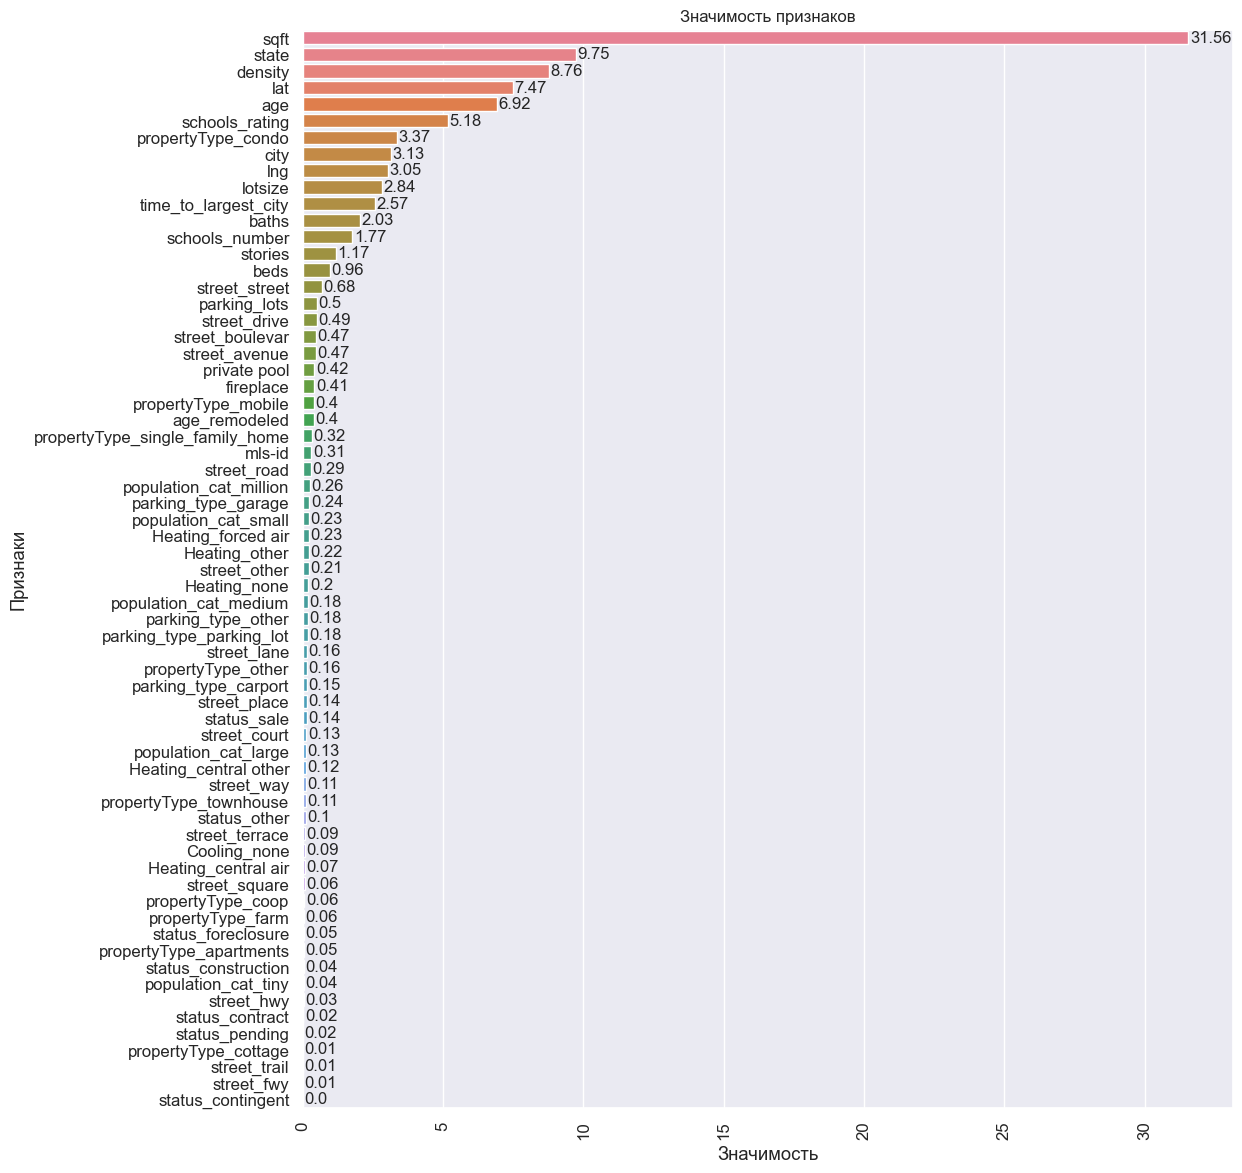

In [722]:
feature_importances_plot(rf.feature_names_in_, rf.feature_importances_)

Неплохие (относительно) результаты. Но вдруг получится лучше? Попробуем градиентный бустинг:

***
### CatBoost + RFECV

In [723]:
model_catboost=CatBoostRegressor(
    eval_metric='MAPE',
    iterations=2e+4,
    random_seed=random_state,
    learning_rate=0.09,
    depth=10,
    early_stopping_rounds=100
    )
model_catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [724]:
show_scores(X_train, X_test, y_train, y_test, model_catboost)

Тренировочная выборка: МAЕ = 24204.978, MAPE = 0.082, R^2 = 0.988
Тестовая выборка: МAЕ = 76332.251, MAPE = 0.208, R^2 = 0.838


Посмотрим на значимость признаков:

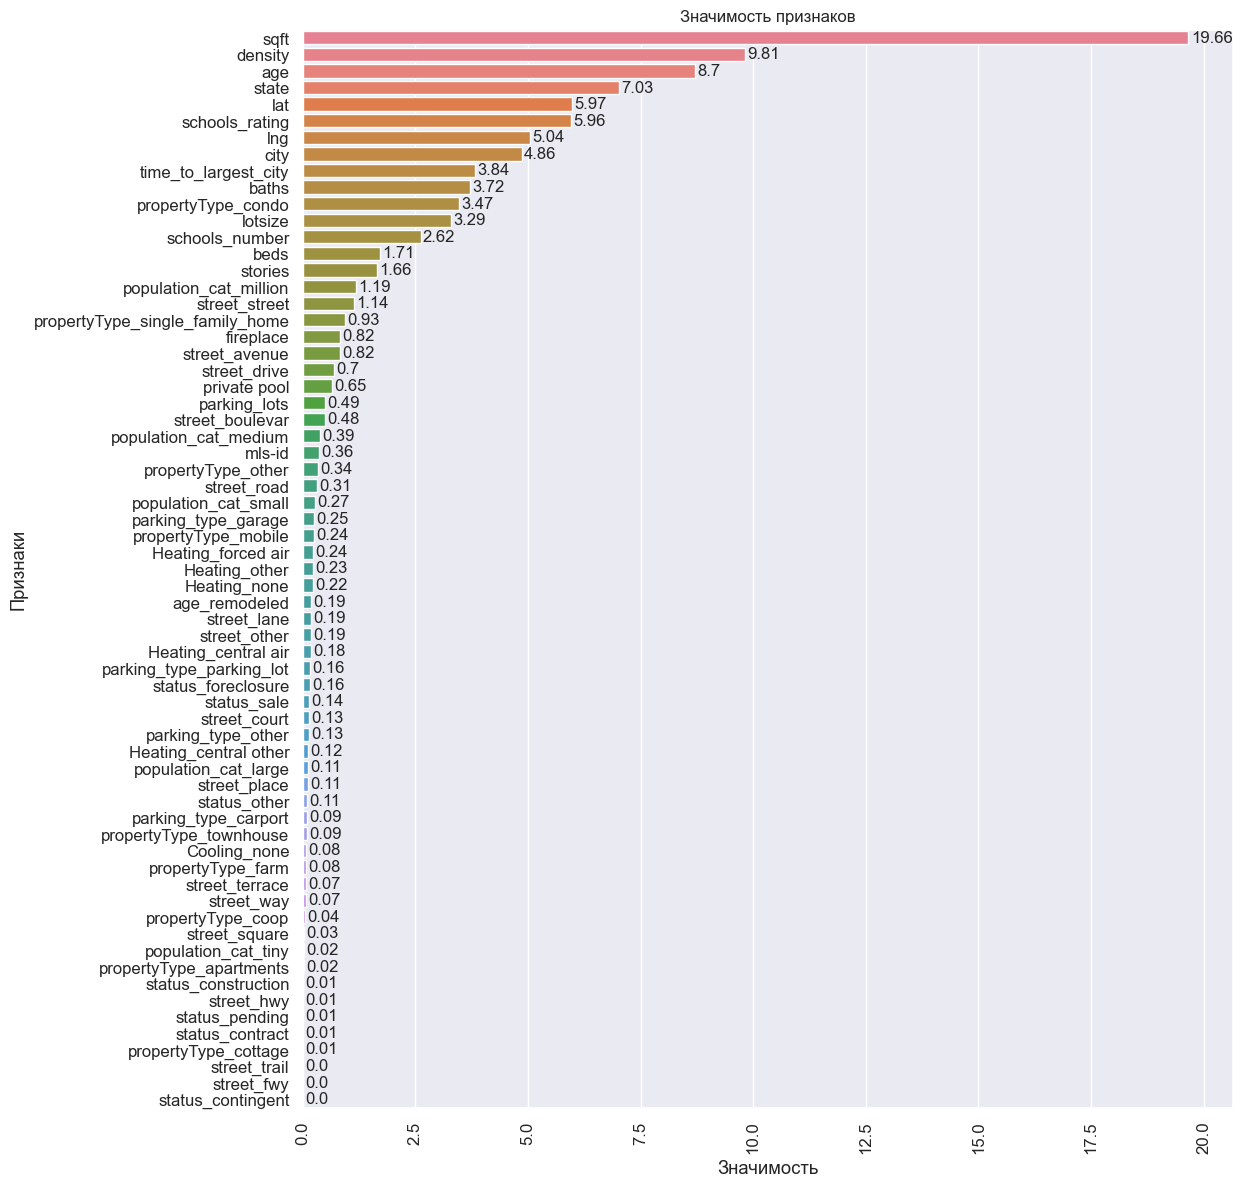

In [725]:
feature_importances_plot(model_catboost.feature_names_, model_catboost.feature_importances_)

Получившиеся метрики лучше, чем у случайного леса. Отберём лучшие признаки с помощью [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV):

Optimal number of features: 34


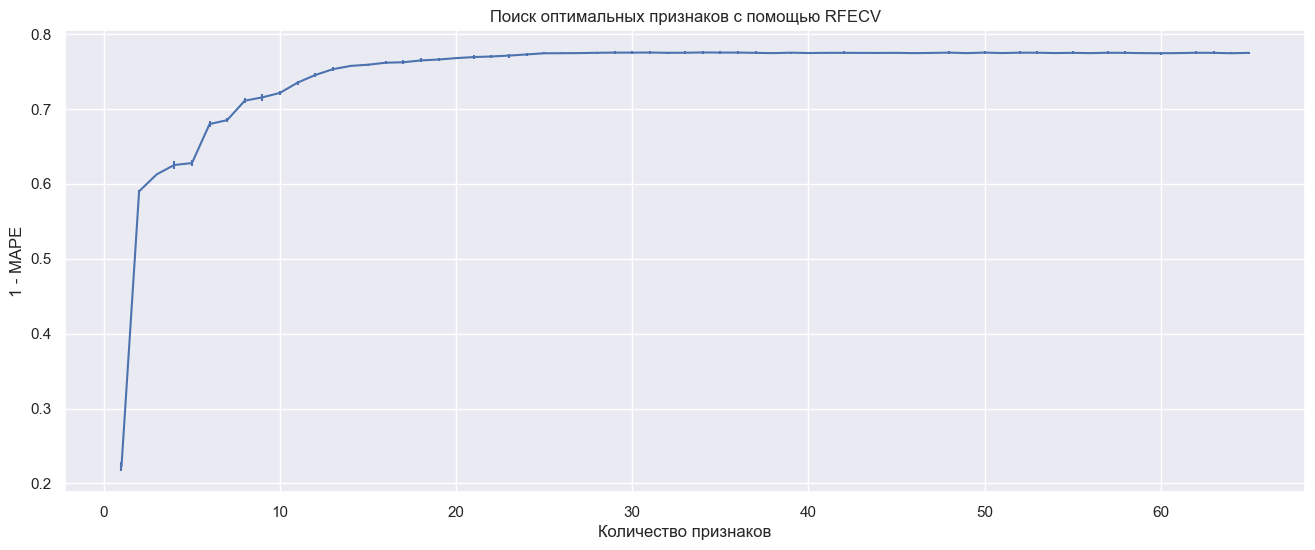

Количество признаков было: 65
Количество признаков стало: 34


In [726]:
model = CatBoostRegressor(eval_metric='MAPE', verbose=False)
rfecv = RFECV(estimator=model, cv=5, n_jobs=-1)

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
pipeline.fit(X_train, y_train)

print('Optimal number of features:', rfecv.n_features_)

n_features = len(rfecv.cv_results_['mean_test_score'])
plt.figure(figsize=(16,6))
plt.xlabel('Количество признаков')
plt.ylabel("1 - MAPE")
plt.errorbar(
    range(rfecv.min_features_to_select, n_features + rfecv.min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Поиск оптимальных признаков с помощью RFECV")
plt.show();

X_train_opt = X_train[rfecv.get_feature_names_out()]
X_test_opt = X_test[rfecv.get_feature_names_out()]
print(f'Количество признаков было: {X_train.shape[1]}')
print(f'Количество признаков стало: {X_train_opt.shape[1]}')

Поскольку ищет он достаточно долго, выведем список фич напрямую:

In [727]:
# rfecv_list = [
#     'private pool', 'baths', 'fireplace', 'sqft', 'beds', 'state', 'stories', 'mls-id', 'lotsize', 'age', 'age_remodeled', 'schools_number', 'schools_rating',
#     'lat', 'lng', 'density', 'time_to_largest_city', 'status_foreclosure', 'propertyType_single_family_home', 'propertyType_other', 'propertyType_condo',
#     'propertyType_mobile', 'street_avenue', 'street_street', 'street_drive', 'street_boulevar', 'population_cat_small', 'population_cat_million', 'population_cat_medium',
#     'city']
# X_train_opt = X_train[rfecv_list]
# X_test_opt = X_test[rfecv_list]
# print(f'Количество признаков было: {X_train.shape[1]}')
# print(f'Количество признаков стало: {X_train_opt.shape[1]}')

Обучим модель на этих признаках:

In [728]:
model_catboost_opt=CatBoostRegressor(
    eval_metric='MAPE',
    iterations=2e+4,
    random_seed=random_state,
    learning_rate=0.09,
    depth=10,
    early_stopping_rounds=100
    )
model_catboost_opt.fit(
    X_train_opt, y_train,
    # cat_features=cat_features,
    eval_set=(X_test_opt, y_test),
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [729]:
show_scores(X_train_opt, X_test_opt, y_train, y_test, model_catboost_opt)

Тренировочная выборка: МAЕ = 26986.819, MAPE = 0.091, R^2 = 0.985
Тестовая выборка: МAЕ = 76856.860, MAPE = 0.210, R^2 = 0.835


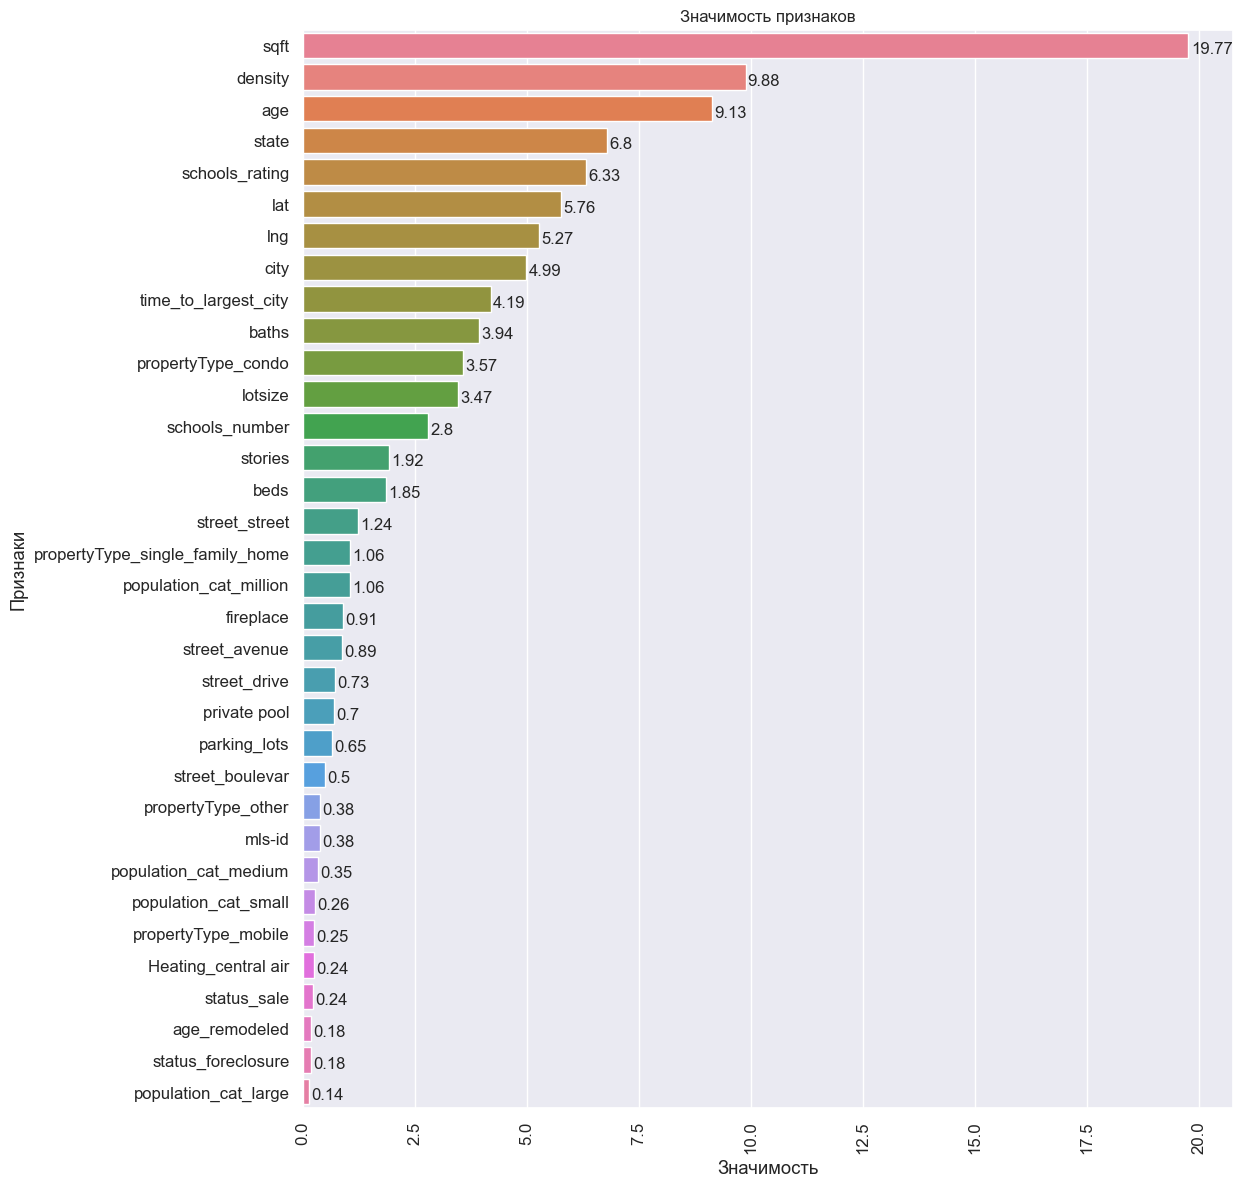

In [730]:
feature_importances_plot(model_catboost_opt.feature_names_, model_catboost_opt.feature_importances_)

***
### Заключение

Финальный результат по метрике MAPE = 20.6% при всех признаках и MAPE = 20.7% для отобранных 30.

Обученная модель показала относительно неплохие метрики. Однако, к сожалению, подобная модель слабо применима в реальной жизни. Даже оптимизация гиперпараметров не дала бы хорошего качества модели. В нашем датасете перед отправкой в модель диапазон целевого признака был от $30K до $3M и если для максимальной цены средняя абсолютная ошибка в $80K это вполне допустимо, до для минимальной совершенно неприемлемо.

Можно предположить, что именно это послужило причиной низкой точности. Стоило бы разделить датасет на различные ценовые диапазоны и для каждого построить свою модель. Также можно было бы построить модель и для земельных участков, и для аренды, если бы было достаточно наблюдений. Мы здесь этого делать не будем.

***
### Продакшн

In [731]:
import pickle

model = pickle.dumps(model_catboost_opt)

In [732]:
with open('model_catboost.pkl', 'wb') as output:
    pickle.dump(model_catboost_opt, output)